In [84]:
import pandas as pd
import numpy as np
import re
import glob
from pathlib import Path
from captum.attr import IntegratedGradients
from NegativeClassOptimization.preprocessing import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import torch


In [85]:
from tqdm import tqdm

## Finding correct mutants

In [86]:
#get number of mutations from ID
def get_mutations(ID):
    try:
        n_mut = re.search('([0-9])m',ID).group(1)
        return int(n_mut)
    except:
        return np.NaN

In [87]:
def find_ids(ID):
    try:
        first_id = re.match('[A-Z_]*([0-9]+_[0-9]*[a-z])',ID).group(1)
        return first_id
    except:
        return 'unknown'

In [88]:
def prep_mut_df(mut_folder):
    mut_file = pd.read_csv(mut_path / f'{mut_folder}/PooledTempResults_merged.txt', sep=' ')
    mut_file['n_mut'] = mut_file['ID_slide_Variant'].apply(get_mutations)
    mut_file['ID'] = mut_file['ID_slide_Variant'].apply(find_ids)
    return mut_file

In [89]:
# find mutated slides corresponding to slides from test set
def get_org_slide_id(mut_file, wt_path):
    wt_file = pd.read_csv(wt_path, sep='\t')
    wt_test = wt_file[wt_file['y'] == 1] 
    wt_slides = set(wt_test.Slide)
    int_slides = set(mut_file[mut_file['n_mut'] == 0]['Slide']).intersection(wt_slides)
    slide_id = mut_file[mut_file['Slide'].isin(int_slides) & (mut_file['n_mut']==0)][['Slide', 'ID', 'Energy']]
    return slide_id

In [22]:
# in the simulation a mutattion is also a shift in 11 mer, this function finds point mutations without changing the 11mer
"""def get_mut_patterns(slide):
    ex_slide_list = list(slide)
    mut_patterns = []
    for i in range(11):
        mut_pattern = ex_slide_list[:i] + [f'[^{ex_slide_list[i]}]']
        if i < 10:
            mut_pattern = mut_pattern + ex_slide_list[i+1:]
        mut_patterns.append(((i),''.join(mut_pattern)))
    return mut_patterns"""

In [122]:
import copy
from itertools import combinations
def get_mut_patterns(slide, n_mut=[1]):
    seq = list(slide)
    pos = np.arange(0, 11)
    substitutions = []
    for n in n_mut:
        patterns = list(combinations(pos, n))
        substitutions.extend(patterns)

    res = []
    for sub in substitutions:
        seq_copy = copy.deepcopy(seq)
        for i in sub:
            seq_copy[i] = f'[^{seq_copy[i]}]'
        res.append((sub,''.join(seq_copy)))
    return res


In [121]:
res = get_mut_patterns(seq, [2,3])

In [ ]:
for i, pattern in res:
    print(i)

In [112]:
def ig_from_oh(oh_slide,ig,baseline):
    oh_slide = np.array(oh_slide)
    oh_slide = torch.tensor(oh_slide).float()
    attr = ig.attribute(oh_slide, baseline)
    attr = attr.squeeze()
    attr = attr.reshape(11, -1)
    attr = attr.detach().numpy()
    aa_attr = list(map(sum, attr))
    return aa_attr

In [123]:
def mutant_ig(ig,mut_file, slide_id, n_mut=[1], count_pos_ig = False):
    dfs_list = []
    for slide, ID, Energy, degrees in  slide_id.values:
        mut_patterns = get_mut_patterns(slide, n_mut) #needed so there is no shift in Slide
        df_search = mut_file[(mut_file['ID'] == ID) & (mut_file['n_mut'].isin(n_mut)) & (mut_file['Slide']!=slide)].copy(deep=True)
        df_search['original Slide'] = slide
        org_slide_oh = torch.tensor(np.array([[onehot_encode(slide)]])).float()
        df_search['IG org'] = [ig_from_oh(org_slide_oh, ig, baseline)]*df_search.shape[0]
        df_search['Energy org'] = [Energy]*df_search.shape[0]

        for i, pattern in mut_patterns:
            df_pos_mut = df_search[df_search['Slide'].str.contains(pattern)].copy(deep=True)
            df_pos_mut['mut OH'] = df_pos_mut['Slide'].apply(lambda x: [[onehot_encode(x)]])
            df_pos_mut['IG mut'] = df_pos_mut['mut OH'].apply(lambda x: ig_from_oh(x,ig,baseline))
            df_pos_mut['dEnergy'] = [Energy]*df_pos_mut.shape[0] - df_pos_mut['Energy']
            if count_pos_ig:
                df_pos_mut['degree wt'] = int(degrees[i][1])
                df_pos_mut['posn IG mut'] = df_pos_mut['IG mut'].apply(lambda x: x[i])
                df_pos_mut['posn IG org'] = df_pos_mut['IG org'].apply(lambda x: x[i])
                df_pos_mut['posn delta IG'] =  df_pos_mut['posn IG org'] - df_pos_mut['posn IG mut']
            dfs_list.append(df_pos_mut)
    return pd.concat(dfs_list)
            

## Finding best model

In [114]:
#open and closed performances
perf_df = pd.read_csv('../data/openset_performance.tsv', sep='\t')
perf_df[['train_task', 'train_ag', 'train_neg', 'seed_id', 'split_id']] = perf_df.task_1.str.split('__', expand=True)
perf_df[['test_task', 'test_ag', 'test_neg', 'test_seed_id', 'test_split_id']] = perf_df.task_2.str.split('__', expand=True)
perf_df.drop(['task_1', 'task_2'], inplace=True, axis=1)

In [115]:
#choose the best model in terms of closed performance
def get_best_model_seed_split(df, train_task, test_task, ag, metric):
    task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
    best_row = task_df[task_df['acc'] == task_df['acc'].max()]
    seed_id = best_row['seed_id'].values[0]
    split_id = best_row['split_id'].values[0]
    return seed_id , split_id

In [116]:
tasks = ['ONE_VS_NINE', 'HIGH_VS_95LOW', 'HIGH_VS_LOOSER']
tasks_dict = {'ONE_VS_NINE': '1v9', 'HIGH_VS_95LOW': 'high_vs_95low', 'HIGH_VS_LOOSER': 'high_vs_looser'}
task_template = {'ONE_VS_NINE': '{ag}__vs__9', 'HIGH_VS_95LOW': '{ag}_high__vs__{ag}_95low', 'HIGH_VS_LOOSER': '{ag}_high__vs__{ag}_looser'}

In [117]:
perf_df.head()

acc  recall  precision        f1     train_task train_ag train_neg  \
0  0.972986   0.975   0.971116  0.973054    ONE_VS_NINE     3VRL      auto   
1  0.987000   0.975   0.998975  0.986842    ONE_VS_NINE     3VRL      auto   
2  0.882900   0.975   0.823341  0.892775    ONE_VS_NINE     3VRL      auto   
3  0.912356   0.998   0.852117  0.919307  HIGH_VS_95LOW     3VRL      auto   
4  0.996600   0.998   0.995213  0.996605  HIGH_VS_95LOW     3VRL      auto   

  seed_id split_id       test_task test_ag test_neg test_seed_id test_split_id  
0       0       42     ONE_VS_NINE    3VRL     auto            0            42  
1       0       42   HIGH_VS_95LOW    3VRL     auto            0            42  
2       0       42  HIGH_VS_LOOSER    3VRL     auto            0            42  
3       0       42     ONE_VS_NINE    3VRL     auto            0            42  
4       0       42   HIGH_VS_95LOW    3VRL     auto            0            42

# Plotting

In [100]:
def single_mut_plot(df, task, pic_name):
    color = get_color(task)
    df['posn delta IG'] = df['posn delta IG'].astype(float)
    df['dEnergy'] = df['dEnergy'].astype(float)
    g = sns.scatterplot(df, x = 'posn delta IG', y='dEnergy', s=20, color=color)#hue='degree wt'
    #g = sns.lmplot(data=df, x = 'posn delta IG', y='dEnergy', hue = 'degree wt', palette = 'colorblind');
    g.set(xlabel='Δ Energy', ylabel='Δ position IG')
    #g.set(title='loose binders')
    #plt.savefig(f'./plots/{pic_name}.png')
    plt.show()

In [98]:
def get_corr(df, columns):
    for column in columns:
        df[column] = pd.to_numeric(df[column])
    pers_corr = df[columns].corr().iloc[0,1]
    pers_corr = round(pers_corr,2)
    return pers_corr

In [99]:
def get_color(task):
    if task == 'ONE_VS_NINE' :
        color= '#FF5733'
    elif task == 'HIGH_VS_95LOW':
        color = '#00A6ED'
    else:
        color = '#FFC300'
    return color

## Get degree of mutated amino-acid

In [101]:
def get_aa_degree(y_deg):
    y_deg = [*y_deg[:-1]]
    n = 2
    y_deg = [y_deg[i: i+n] for i in range(0, len(y_deg), n)]
    return y_deg
def full_slide_degree(y_slide, y_deg):
    y_slide = [*y_slide]
    y_deg =  get_aa_degree(y_deg)
    j = 0
    deg_full = []
    for i in range(len(y_slide)):
        if y_slide[i] == y_deg[j][0]:
            aa_deg = ''.join(y_deg[j])
            if j < len(y_deg)-1:
                j +=1
        else:
            aa_deg = y_slide[i] +'0'
        deg_full.append(aa_deg)
    return deg_full

## Get dependabce between pos ID and Energy between wt and mutated  Slide

In [118]:
#standart for all
baseline = torch.tensor([[[0.0]*220]])
mut_path = Path('../data/mutated_t6')

In [139]:
for ag in config.ANTIGENS:
    print(ag)
    wt_path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/1v9/seed_0/split_0/{ag}__vs__9/*_test_dataset.tsv')[0] #this part with for loop is repeated a often, probably I just should store these dfs
    mut_file = prep_mut_df(ag)
    slide_id_df = get_org_slide_id(mut_file, wt_path)
    #getting aa degrees
    path_epi = glob.glob(f'../data/Slide_importance/{ag}_[A-Z]_Task4_Slice_ParaEpi.txt')[0]
    para_epi = pd.read_csv(path_epi, sep='\t')
    slide_id_df= slide_id_df.merge(para_epi[['Slide', 'seqABParatope']], on=['Slide'], how='left')
    slide_id_df['aa_degrees'] = slide_id_df.apply(lambda x: full_slide_degree(x.Slide, x.seqABParatope), axis=1)
    slide_id_df.drop('seqABParatope', axis=1, inplace=True)
    slide_id_df.to_csv(f'../data/mutated_t6/wt_slide_id/{ag}_slide_id_df.csv')

3VRL
1NSN
3RAJ
5E94
1H0D
1WEJ
1ADQ
1FBI
2YPV
1OB1


In [ ]:
for ag in config.ANTIGENS:
    print(ag)
    slide_id_df = pd.read_csv(f'../data/mutated_t6/wt_slide_id/{ag}_slide_id_df.csv', index_col=0)
    mut_file = prep_mut_df(ag)
    #convert aa_degrees column to list
    slide_id_df['aa_degrees'] = slide_id_df['aa_degrees'].apply(eval)
    for task in tasks:
        seed_id, split_id = get_best_model_seed_split(perf_df, task, task, ag, 'acc')
        model_path = f"./torch_models/Frozen_MiniAbsolut_ML/{tasks_dict[task]}/seed_{seed_id}/split_{split_id}/{task_template[task].format(ag=ag)}/swa_model/data/model.pth"
        model = torch.load(model_path, map_location=torch.device('cpu'))
        ig = IntegratedGradients(model.cpu())
        mut_igs = mutant_ig(ig,mut_file, slide_id_df, count_pos_ig = True)
        mut_igs.to_csv(f'./mutant_igs/{ag}_{task}_mut_igs.csv', index=False)

In [124]:
#for 2-3 mutations
for ag in config.ANTIGENS:
    print(ag)
    slide_id_df = pd.read_csv(f'../data/mutated_t6/wt_slide_id/{ag}_slide_id_df.csv', index_col=0)
    mut_file = prep_mut_df(ag)
    #convert aa_degrees column to list
    slide_id_df['aa_degrees'] = slide_id_df['aa_degrees'].apply(eval)
    for task in tasks:
        seed_id, split_id = get_best_model_seed_split(perf_df, task, task, ag, 'acc')
        model_path = f"./torch_models/Frozen_MiniAbsolut_ML/{tasks_dict[task]}/seed_{seed_id}/split_{split_id}/{task_template[task].format(ag=ag)}/swa_model/data/model.pth"
        model = torch.load(model_path, map_location=torch.device('cpu'))
        ig = IntegratedGradients(model.cpu())
        mut_igs = mutant_ig(ig,mut_file, slide_id_df, [2,3])
        mut_igs.to_csv(f'./mutant_igs/{ag}_{task}_2-3mut_igs.csv', index=False)

3VRL


/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_9531/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_9531/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_9531/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]


1NSN


/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_9531/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_9531/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_9531/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]


3RAJ


/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_9531/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_9531/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_9531/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]


5E94


/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_9531/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_9531/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_9531/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]


1H0D


/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_9531/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_9531/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_9531/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]


1WEJ


/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_9531/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_9531/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_9531/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]


1ADQ


/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_9531/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_9531/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_9531/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]


1FBI


/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_9531/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_9531/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_9531/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]


2YPV


/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_9531/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_9531/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_9531/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]


1OB1


/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_9531/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_9531/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_9531/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]


In [ ]:
mut_igs.to_csv(f'./mutant_igs/{ag}_{task}_mut_igs.csv', index=False)

In [14]:
slide_id_df

Slide            ID  Energy  \
0   CALISQRIYFD  16405617_00a  -90.00   
1   CTGTDFAWFAY  11351941_02a  -91.25   
2   QLLLRGNWFAY  13034853_03a  -92.19   
3   ALLLRGSIVAY  11682538_05a  -91.55   
4   CATLGSNWDYF  17314056_00a  -90.35   
5   CAKLSNSFAYW  12635943_00a  -90.04   
6   SLLLRSEWFAY  15583126_04a  -91.96   
7   QLRLPTRFDYW   1643209_04a  -91.45   
8   CTREEIGYWYF  11324149_00a  -90.04   
9   EVIVSLNWDWF  15437780_05a -100.85   
10  YYDYDLGFFAY  15640476_04a  -99.21   
11  RLDDYDLAWFA  14789294_03a  -94.92   
12  IVGLRRGFDYW  12102702_03a  -96.50   
13  IKTIDFPLGYF  15795933_05a  -99.84   
14  SLRDYDLAWFA  14634961_03a  -95.23   
15  GLYDYDLSWFA   1988961_05a  -97.18   
16  CARLDDGLDVW  12757102_00a  -91.59   
17  YYDYDLSYFDY  15488861_03a  -92.90   
18  ARLFGPQLLWY  15384567_02a  -92.09   
19  DLLYDYGVLAY  16406518_03a  -90.38   
20  CARRELGLLAY   1916675_00a  -93.54   

                                           aa_degrees  
0   ['C2', 'A2', 'L3', 'I3', 'S0', 'Q1', 'R0', 'I4...  
1   ['C4', 'T2', 'G1', 'T2', 'D0', 'F4', 'A2', 'W3...  
2   ['Q0', 'L4', 'L2', 'L4', 'R1', 'G1', 'N0', 'W3...  
3   ['A1', 'L4', 'L2', 'L4', 'R0', 'G1', 'S0', 'I3...  
4   ['C3', 'A3', 'T2', 'L4', 'G0', 'S2', 'N0', 'W3...  
5   ['C4', 'A2', 'K1', 'L3', 'S0', 'N2', 'S0', 'F4...  
6   ['S0', 'L4', 'L2', 'L4', 'R1', 'S1', 'E0', 'W3...  
7   ['Q3', 'L3', 'R2', 'L4', 'P0', 'T2', 'R0', 'F3...  
8   ['C4', 'T2', 'R1', 'E2', 'E0', 'I4', 'G2', 'Y3...  
9   ['E2', 'V2', 'I3', 'V3', 'S2', 'L4', 'N0', 'W2...  
10  ['Y4', 'Y2', 'D1', 'Y2', 'D0', 'L4', 'G2', 'F3...  
11  ['R2', 'L4', 'D2', 'D1', 'Y2', 'D0', 'L4', 'A2...  
12  ['I3', 'V3', 'G2', 'L4', 'R2', 'R0', 'G0', 'F3...  
13  ['I4', 'K2', 'T1', 'I3', 'D0', 'F2', 'P0', 'L4...  
14  ['S2', 'L4', 'R2', 'D1', 'Y2', 'D0', 'L4', 'A2...  
15  ['G2', 'L4', 'Y2', 'D1', 'Y2', 'D0', 'L4', 'S2...  
16  ['C4', 'A2', 'R1', 'L3', 'D2', 'D0', 'G0', 'L4...  
17  ['Y4', 'Y2', 'D1', 'Y2', 'D0', 'L4', 'S2', 'Y3...  
18  ['A1', 'R4', 'L2', 'F4', 'G0', 'P1', 'Q0', 'L3...  
19  ['D0', 'L4', 'L2', 'Y4', 'D1', 'Y1', 'G0', 'V3...  
20  ['C4', 'A2', 'R1', 'R2', 'E0', 'L4', 'G2', 'L3...

In [111]:
#for shufled models
for ag in config.ANTIGENS:
    print(ag)
    slide_id_df = pd.read_csv(f'../data/mutated_t6/wt_slide_id/{ag}_slide_id_df.csv', index_col=0)
    mut_file = prep_mut_df(ag)
    #convert aa_degrees column to list
    slide_id_df['aa_degrees'] = slide_id_df['aa_degrees'].apply(eval)
    for task in tasks:
        seed_id, split_id = 0, 42
        model_path = f"./torch_models/Frozen_MiniAbsolut_ML_shuffled/{tasks_dict[task]}/seed_{seed_id}/split_{split_id}/{task_template[task].format(ag=ag)}/swa_model/data/model.pth"
        model = torch.load(model_path, map_location=torch.device('cpu'))
        ig = IntegratedGradients(model.cpu())
        mut_igs = mutant_ig(ig,mut_file, slide_id_df)
        mut_igs.to_csv(f'./mutant_igs/{ag}_{task}_shuffled_mut_igs.csv', index=False)

3VRL
1NSN
3RAJ
5E94
1H0D
1WEJ
1ADQ
1FBI
2YPV
1OB1


In [128]:
#for shuffled binders_igs
for ag in config.ANTIGENS:
    wt_path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/1v9/seed_0/split_42/{ag}__vs__9/*_test_dataset.tsv')[0]
    wt_df = pd.read_csv(wt_path, sep='\t')
    binder_df = wt_df[wt_df['y'] == 1]
    binder_df['X'] = binder_df.Slide.apply(onehot_encode)
    # get degree of each slide
    path_epi = glob.glob(f'../data/Slide_importance/{ag}_[A-Z]_Task4_Slice_ParaEpi.txt')[0]
    para_epi = pd.read_csv(path_epi, sep='\t')
    binder_df= binder_df.merge(para_epi[['Slide', 'seqABParatope']], on=['Slide'], how='left')
    binder_df['aa_degrees'] = binder_df.apply(lambda x: full_slide_degree(x.Slide, x.seqABParatope), axis=1)
    binder_df['degrees'] = binder_df['aa_degrees'].apply(lambda d: list(map(lambda x: int(re.search('(\d)',x).group(1)),d)))
    binder_df.drop('seqABParatope', axis=1, inplace=True)

    for task in tasks:
        seed_id, split_id = 0, 42
        model_path = f"./torch_models/Frozen_MiniAbsolut_ML_shuffled/{tasks_dict[task]}/seed_{seed_id}/split_{split_id}/{task_template[task].format(ag=ag)}/swa_model/data/model.pth"
        model = torch.load(model_path, map_location=torch.device('cpu'))
        ig = IntegratedGradients(model.cpu())
        binder_df['IG'] = binder_df.X.apply(lambda x: ig_from_oh(x,ig,baseline))
        binder_df.to_csv(f'./binder_igs/{ag}_{task}_shuffled_binder_igs.csv', index=False)

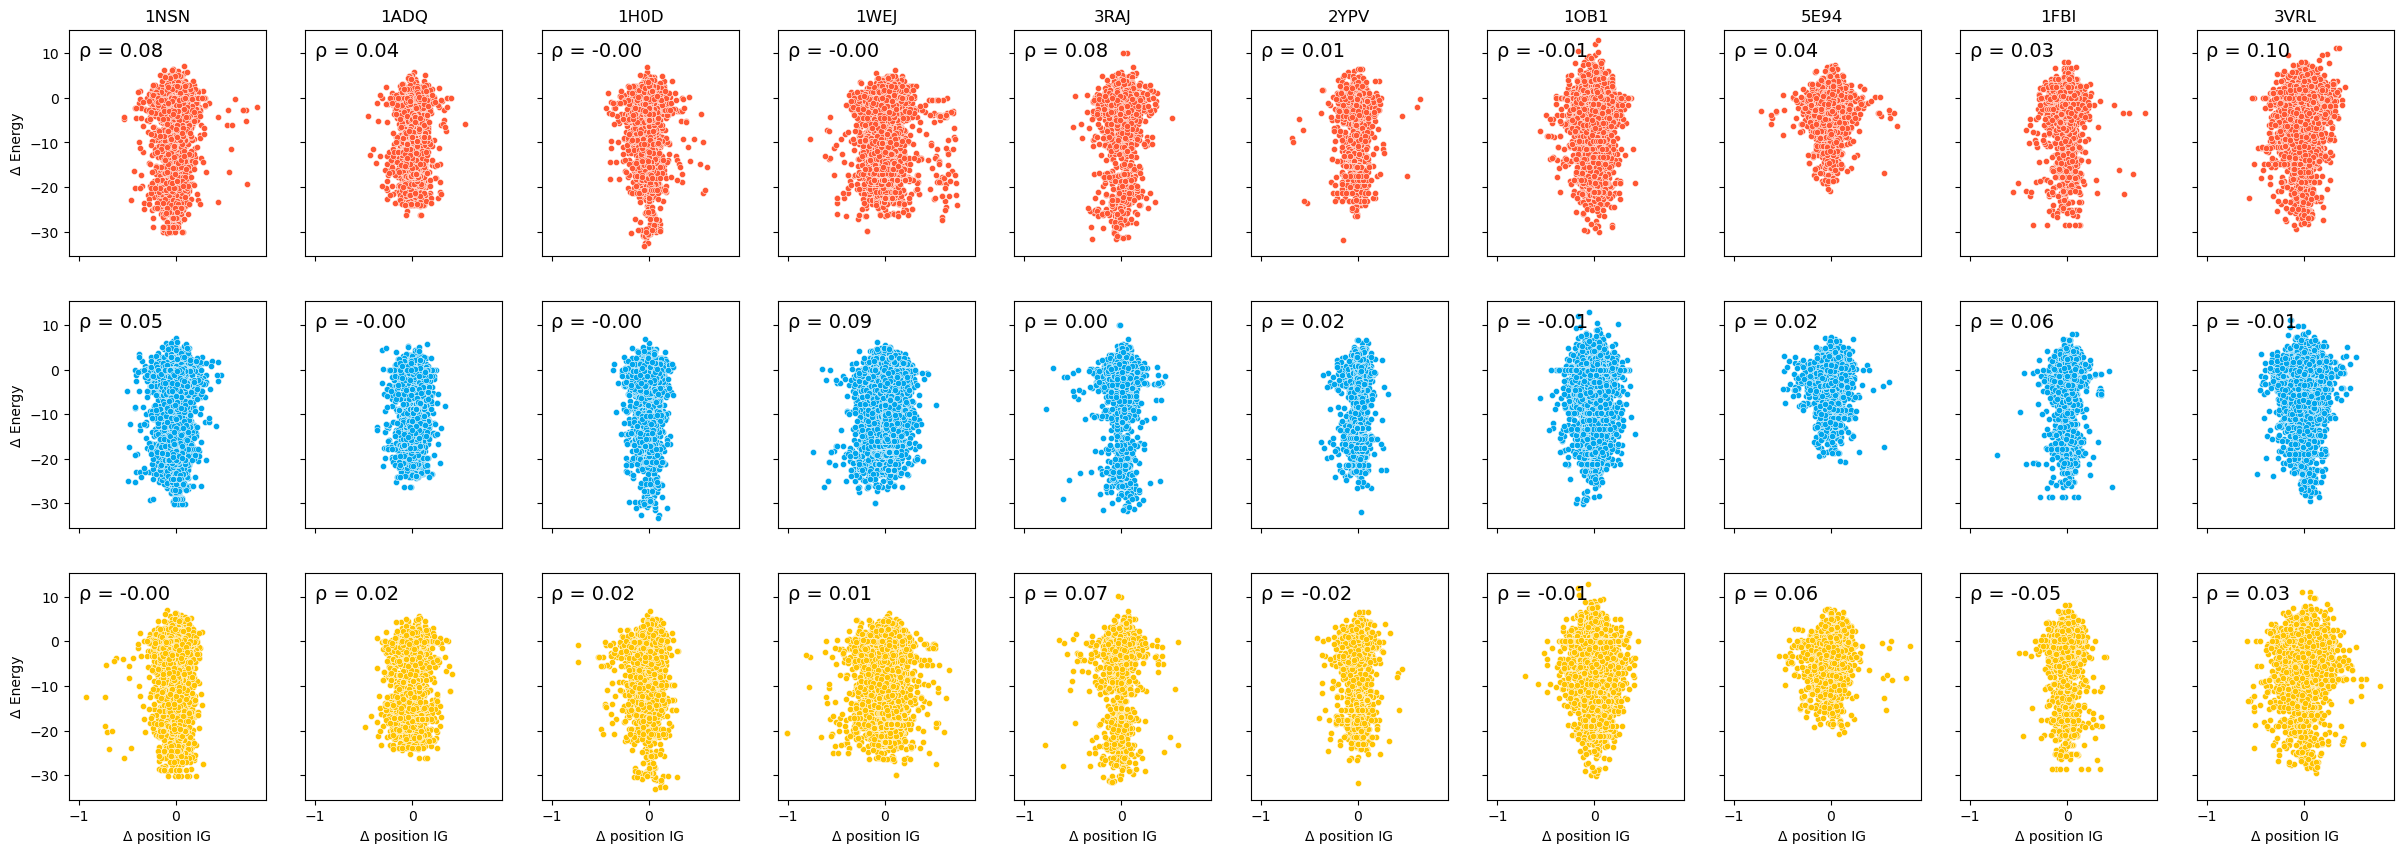

In [140]:
#shuffled
fig, ax = plt.subplots(3,10, figsize=(30,10), sharex=True, sharey=True)
for j, ag in enumerate(order_dict.keys()):
    for i, task in enumerate(tasks):
        mut_ig = pd.read_csv(f'./mutant_igs/{ag}_{task}_shuffled_mut_igs.csv')
        color = get_color(task)
        sns.scatterplot(mut_ig, x = 'posn delta IG', y='dEnergy', s=20, color=color, ax=ax[i,j])#hue='degree wt'
        acc = perf_df[(perf_df['train_ag'] == ag) & (perf_df['train_task'] == task) & (perf_df['test_task'] == task)]['acc'].max()
        acc = round(acc,2)
       #insert text to each sublot
        ax[i,j].text(0.05, 0.95, 'ρ = {:.2f}'.format(np.corrcoef(mut_ig['posn delta IG'].values, mut_ig['dEnergy'].values)[0,1]), transform=ax[i,j].transAxes, fontsize=14, verticalalignment='top')
        ax[i,0].set_ylabel(f'{task}\n\n dEnergy')
        #rename x-axis
        ax[2,j].set_xlabel('Δ position IG')
        #rename y-axis
        ax[i,0].set_ylabel('Δ Energy')
    ax[0,j].set_title(ag)
fig.savefig('./figures/shuffled_mut_igs_eng.svg', dpi=600)


In [44]:
mut_ig.

ID_slide_Variant              CDR3   Best        Slide  \
0     SHH17238587_00a_1m_174_01a    CCRIGLLLRVFDYW  False  CRIGLLLRVFD   
1     SHH17238587_00a_1m_175_01a    CDRIGLLLRVFDYW  False  DRIGLLLRVFD   
2     SHH17238587_00a_1m_176_01a    CERIGLLLRVFDYW  False  ERIGLLLRVFD   
3     SHH17238587_00a_1m_177_01a    CHRIGLLLRVFDYW  False  HRIGLLLRVFD   
4     SHH17238587_00a_1m_178_01a    CIRIGLLLRVFDYW  False  IRIGLLLRVFD   
...                          ...               ...    ...          ...   
6572    H_H1698108_05a_1m_66_01a  CARRCWLLLGWNFDVW  False  ARRCWLLLGWN   
6573    H_H1698108_05a_1m_67_01a  CARRCWLLLGWRFDVW  False  ARRCWLLLGWR   
6574    H_H1698108_05a_1m_68_01a  CARRCWLLLGWSFDVW  False  ARRCWLLLGWS   
6575    H_H1698108_05a_1m_69_01a  CARRCWLLLGWTFDVW  False  ARRCWLLLGWT   
6576    H_H1698108_05a_1m_70_01a  CARRCWLLLGWVFDVW  False  ARRCWLLLGWV   

      Energy          Structure  n_mut            ID original Slide  \
0     -98.73  137569-BDLRDDSLUR    1.0  17238587_00a    ARIGLLLRVFD   
1     -96.30  137569-BDLRDDSLUR    1.0  17238587_00a    ARIGLLLRVFD   
2     -96.49  137569-BDLRDDSLUR    1.0  17238587_00a    ARIGLLLRVFD   
3     -97.44  137569-BDLRDDSLUR    1.0  17238587_00a    ARIGLLLRVFD   
4     -99.94  137569-BDLRDDSLUR    1.0  17238587_00a    ARIGLLLRVFD   
...      ...                ...    ...           ...            ...   
6572  -91.08  137570-BSDLRDDSLU    1.0   1698108_05a    ARRCWLLLGWY   
6573  -91.31  137570-BSDLRDDSLU    1.0   1698108_05a    ARRCWLLLGWY   
6574  -91.34  137570-BSDLRDDSLU    1.0   1698108_05a    ARRCWLLLGWY   
6575  -92.64  137570-BSDLRDDSLU    1.0   1698108_05a    ARRCWLLLGWY   
6576  -98.80  137570-BSDLRDDSLU    1.0   1698108_05a    ARRCWLLLGWY   

                                                 IG org  Energy org  \
0     [-0.6026529054738148, -0.30733000198856714, 0....      -97.81   
1     [-0.6026529054738148, -0.30733000198856714, 0....      -97.81   
2     [-0.6026529054738148, -0.30733000198856714, 0....      -97.81   
3     [-0.6026529054738148, -0.30733000198856714, 0....      -97.81   
4     [-0.6026529054738148, -0.30733000198856714, 0....      -97.81   
...                                                 ...         ...   
6572  [-0.7245228320225007, -0.5361087692375762, -0....      -97.09   
6573  [-0.7245228320225007, -0.5361087692375762, -0....      -97.09   
6574  [-0.7245228320225007, -0.5361087692375762, -0....      -97.09   
6575  [-0.7245228320225007, -0.5361087692375762, -0....      -97.09   
6576  [-0.7245228320225007, -0.5361087692375762, -0....      -97.09   

                                                 mut OH  \
0     [[array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0...   
1     [[array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0...   
2     [[array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0...   
3     [[array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0...   
4     [[array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0...   
...                                                 ...   
6572  [[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0...   
6573  [[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0...   
6574  [[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0...   
6575  [[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0...   
6576  [[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0...   

                                                 IG mut  degree wt  \
0     [-0.04171210724401178, -0.06580943623932223, 0...          1   
1     [-0.3106673617176272, -0.13521437464349212, 0....          1   
2     [-0.3719999349552573, -0.17749987330551004, 0....          1   
3     [-0.49791802430144533, -0.21293361350836534, 0...          1   
4     [0.11267691783326406, -0.048492403489295045, 0...          1   
...                                                 ...        ...   
6572  [-0.15922866158408733, -0.12121519320118045, -...          4   
6573  [-0.03218591935077693, -0.01900173225590018, -...          4   
6574  [-0.005869401708612593, -0.0036154438379725445...          4   
6575  [-0.02

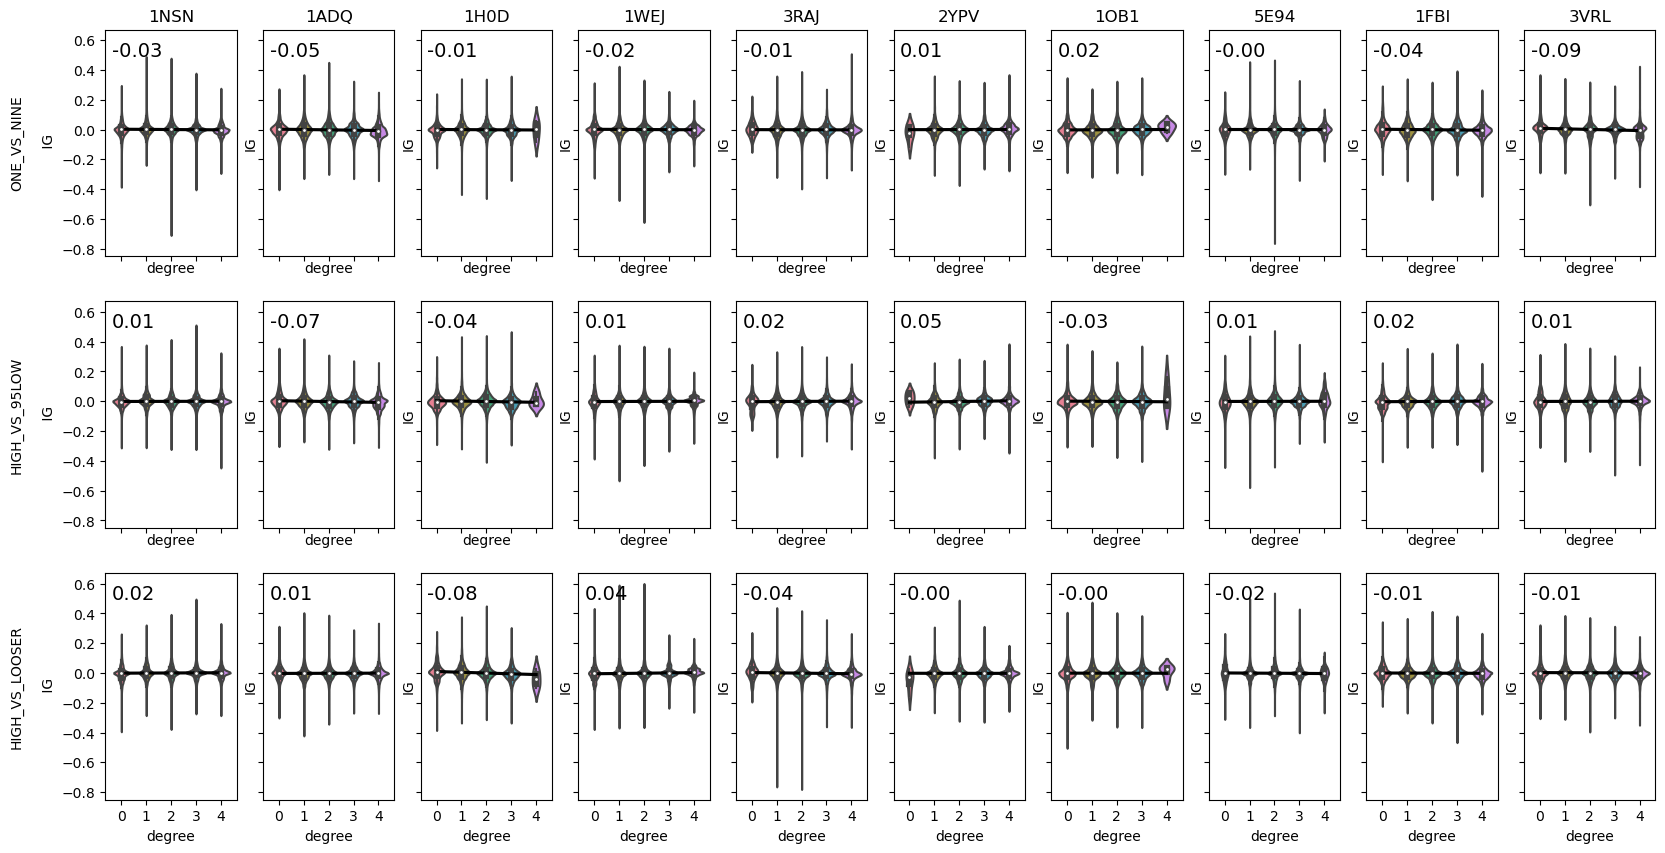

In [134]:
#shuffled
fig, ax = plt.subplots(3,10, sharex=True, sharey=True, figsize=(20,10))
for i, task in enumerate(tasks):
    for j, ag in enumerate(order_dict.keys()):
        #converters = {'IG': pd.eval, 'degrees': pd.eval}
        ig_df = pd.read_csv(f'./binder_igs/{ag}_{task}_shuffled_binder_igs.csv')
        ig_df['IG'] = ig_df['IG'].apply(eval)
        ig_df['degrees'] = ig_df['degrees'].apply(eval)
        # create df with ig and degree correspondance 
        igs = np.concatenate(ig_df['IG'].values).astype(float)
        degrees = np.concatenate(ig_df['degrees'].values).astype(int)
        df_degree_ig = pd.DataFrame.from_dict({'degree': degrees, 'IG': igs})

        r = i
        c = j
        sns.violinplot(df_degree_ig,x='degree', y='IG', ax=ax[r,c], palette='husl')
        sns.regplot(df_degree_ig,x='degree', y='IG', ax=ax[r,c], scatter=False, color='black')
        ax[r,c].text(0.05, 0.95, '{:.2f}'.format(np.corrcoef(df_degree_ig['degree'].values, df_degree_ig['IG'].values)[0,1]), transform=ax[r,c].transAxes, fontsize=14, verticalalignment='top')
        #title of sublots
        ax[0,c].set_title(ag)
    ax[r,0].set_ylabel(f'{task}\n\n IG')
plt.savefig('./figures/shuffled_mut_igs_degree.svg', dpi=600)

In [17]:
ag = '3VRL'
task = 'ONE_VS_NINE'
perf_df[(perf_df['train_ag'] == ag) & (perf_df['train_task'] == task) & (perf_df['test_task'] == task)]['acc'].max()

0.9757878939469736

In [31]:
task = 'ONE_VS_NINE'
order_dict = dict()
for j, ag in enumerate(config.ANTIGENS): 
    df_a = pd.read_csv(f'./mutant_igs/{ag}_{task}_mut_igs.csv')
    order_dict[ag] = np.corrcoef(df_a['posn delta IG'].values, df_a['dEnergy'].values)[0,1]

    #df_a.groupby('ag')
   # ['posn delta IG'].values, mut_ig['dEnergy'].


In [32]:
order_dict.values()

dict_values([-0.6332871387503727, -0.0731364179506543, -0.3826729350872268, -0.5957854467971937, -0.25654381421257655, -0.3592023052612792, -0.19393809492531638, -0.6084262877631836, -0.40633993810267094, -0.5235755389593202])

In [33]:
order_dict = {k: v for k, v in sorted(order_dict.items(), key=lambda item: item[1], reverse=True)}

In [34]:
order_dict.keys()

dict_keys(['1NSN', '1ADQ', '1H0D', '1WEJ', '3RAJ', '2YPV', '1OB1', '5E94', '1FBI', '3VRL'])

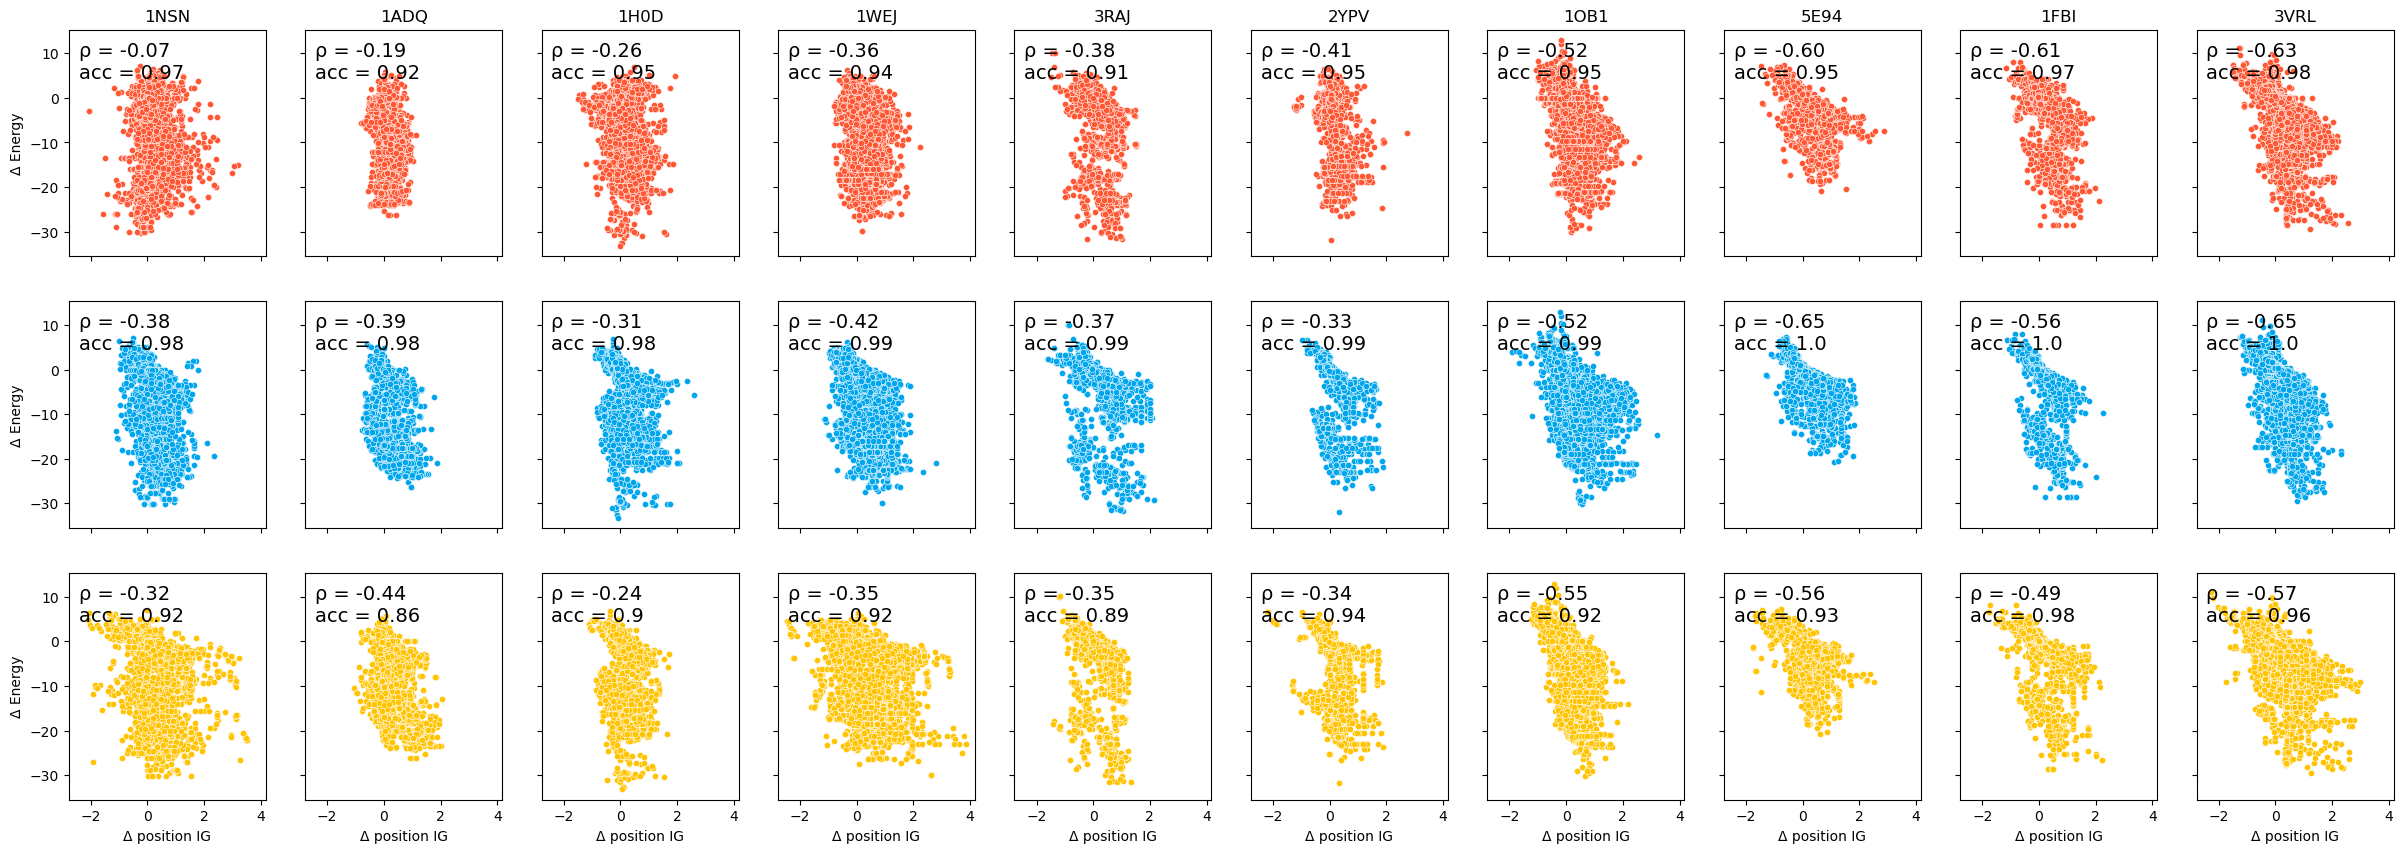

In [35]:
fig, ax = plt.subplots(3,10, figsize=(30,10), sharex=True, sharey=True)
for j, ag in enumerate(order_dict.keys()):
    for i, task in enumerate(tasks):
        mut_ig = pd.read_csv(f'./mutant_igs/{ag}_{task}_mut_igs.csv')
        color = get_color(task)
        sns.scatterplot(mut_ig, x = 'posn delta IG', y='dEnergy', s=20, color=color, ax=ax[i,j])#linewidth=0.02
        acc = perf_df[(perf_df['train_ag'] == ag) & (perf_df['train_task'] == task) & (perf_df['test_task'] == task)]['acc'].max()
        acc = round(acc,2)
       #insert text to each sublot
        ax[i,j].text(0.05, 0.95, 'ρ = {:.2f}\nacc = {acc}'.format(np.corrcoef(mut_ig['posn delta IG'].values, mut_ig['dEnergy'].values)[0,1], acc=acc), transform=ax[i,j].transAxes, fontsize=14, verticalalignment='top')
        ax[i,0].set_ylabel(f'{task}\n\n dEnergy')
        #rename x-axis
        ax[2,j].set_xlabel('Δ position IG')
        #rename y-axis
        ax[i,0].set_ylabel('Δ Energy')
    ax[0,j].set_title(ag)
fig.savefig('./figures/mut_igs_eng.svg')

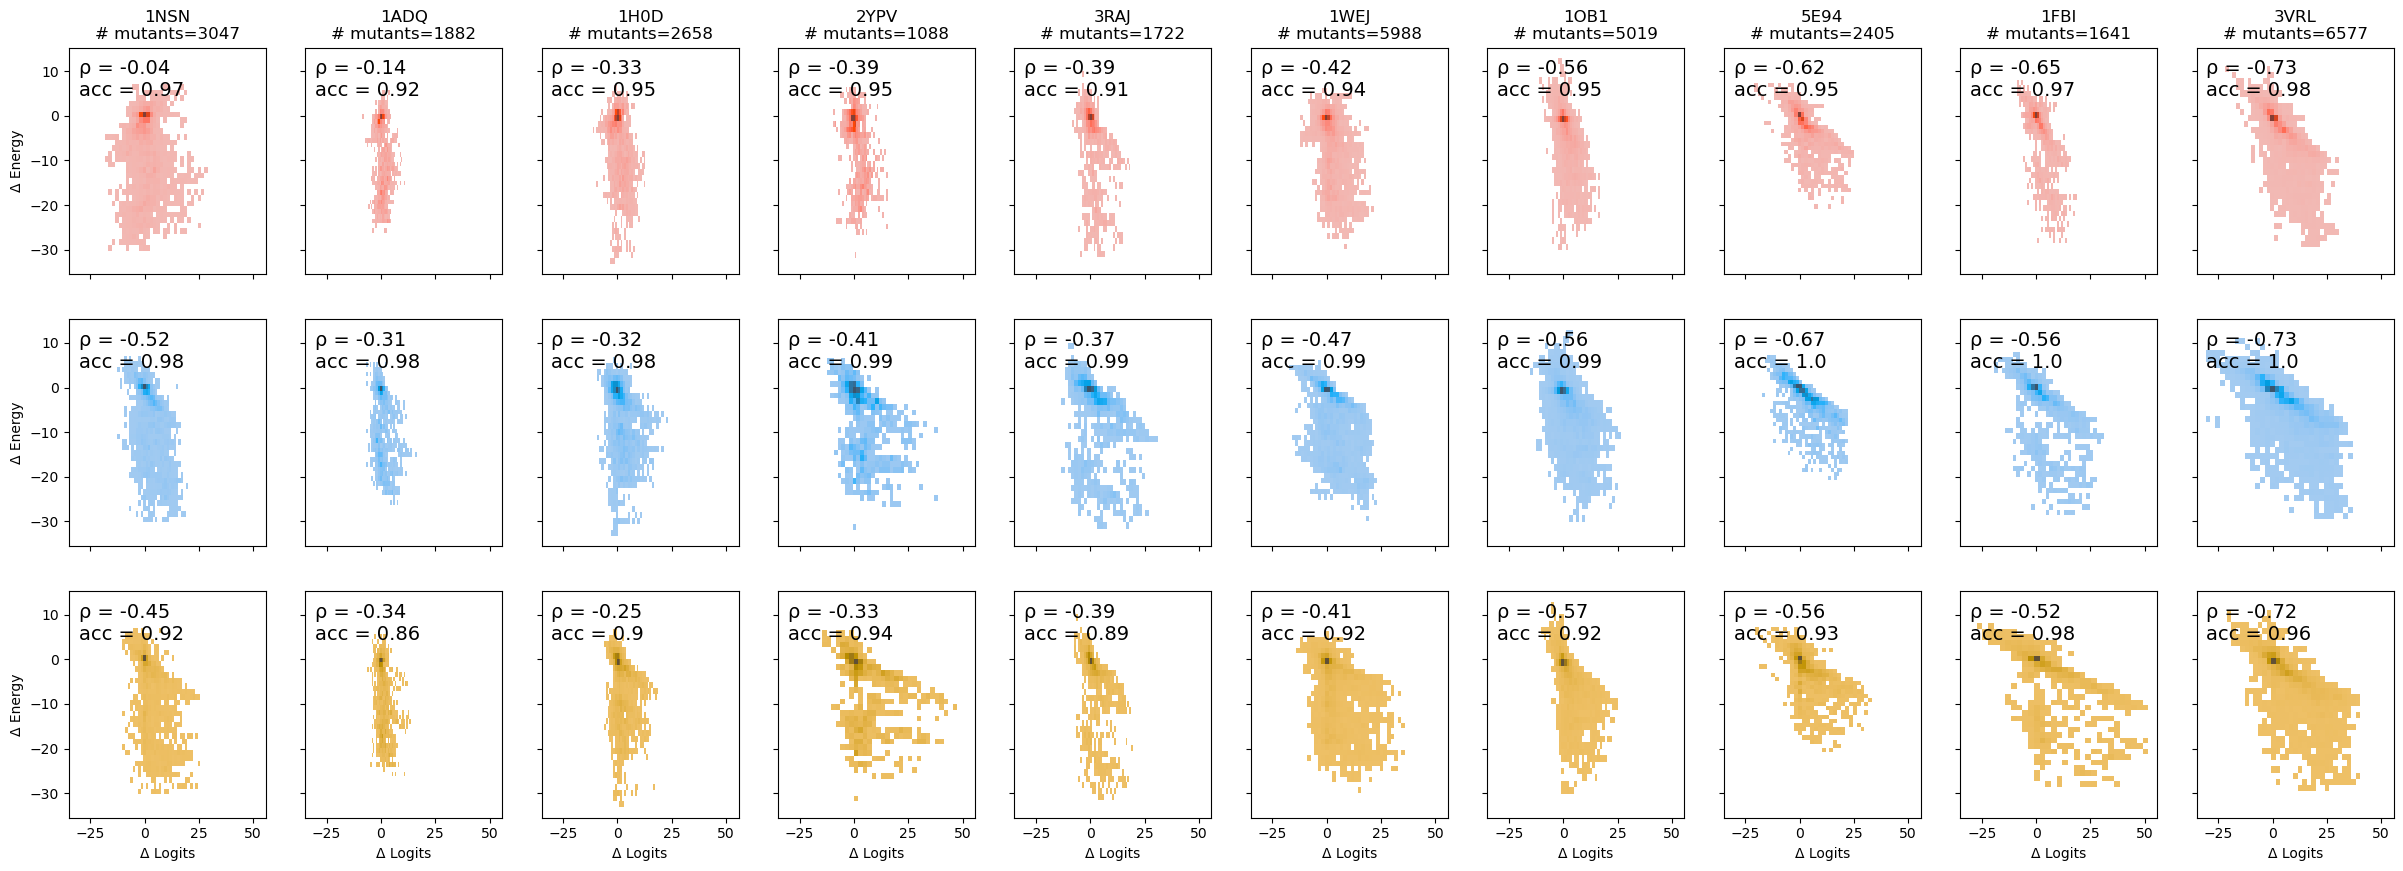

In [26]:
fig, ax = plt.subplots(3,10, figsize=(30,10), sharex=True, sharey=True)
for j, ag in enumerate(order_dict.keys()):
    for i, task in enumerate(tasks):
        mut_ig = pd.read_csv(f'./mutant_igs/{ag}_{task}_mut_igs.csv')
        color = get_color(task)
        sns.histplot(mut_ig, x = 'dLogits', y='dEnergy',color=color, ax=ax[i,j], bins=30)
        #ax[i,j].hist2d(x = mut_ig['dLogits'], y=mut_ig['dEnergy'],cmap=color, bins=50)
        #sns.scatterplot(mut_ig, x = 'dLogits', y='dEnergy', s=20, color=color, ax=ax[i,j])#linewidth=0.02
        acc = perf_df[(perf_df['train_ag'] == ag) & (perf_df['train_task'] == task) & (perf_df['test_task'] == task)]['acc'].max()
        acc = round(acc,2)
        r = np.corrcoef(mut_ig['dLogits'].values, mut_ig['dEnergy'].values)[0,1]
        n = len(mut_ig)
       #insert text to each sublot
        ax[i,j].text(0.05, 0.95, 'ρ = {:.2f}\nacc = {acc}'.format(r, acc=acc), transform=ax[i,j].transAxes, fontsize=14, verticalalignment='top')
        ax[i,0].set_ylabel(f'{task}\n\n dEnergy')
        #rename x-axis
        ax[2,j].set_xlabel('Δ Logits')
        #rename y-axis
        ax[i,0].set_ylabel('Δ Energy')
    ax[0,j].set_title(f'{ag}\n# mutants={n}')

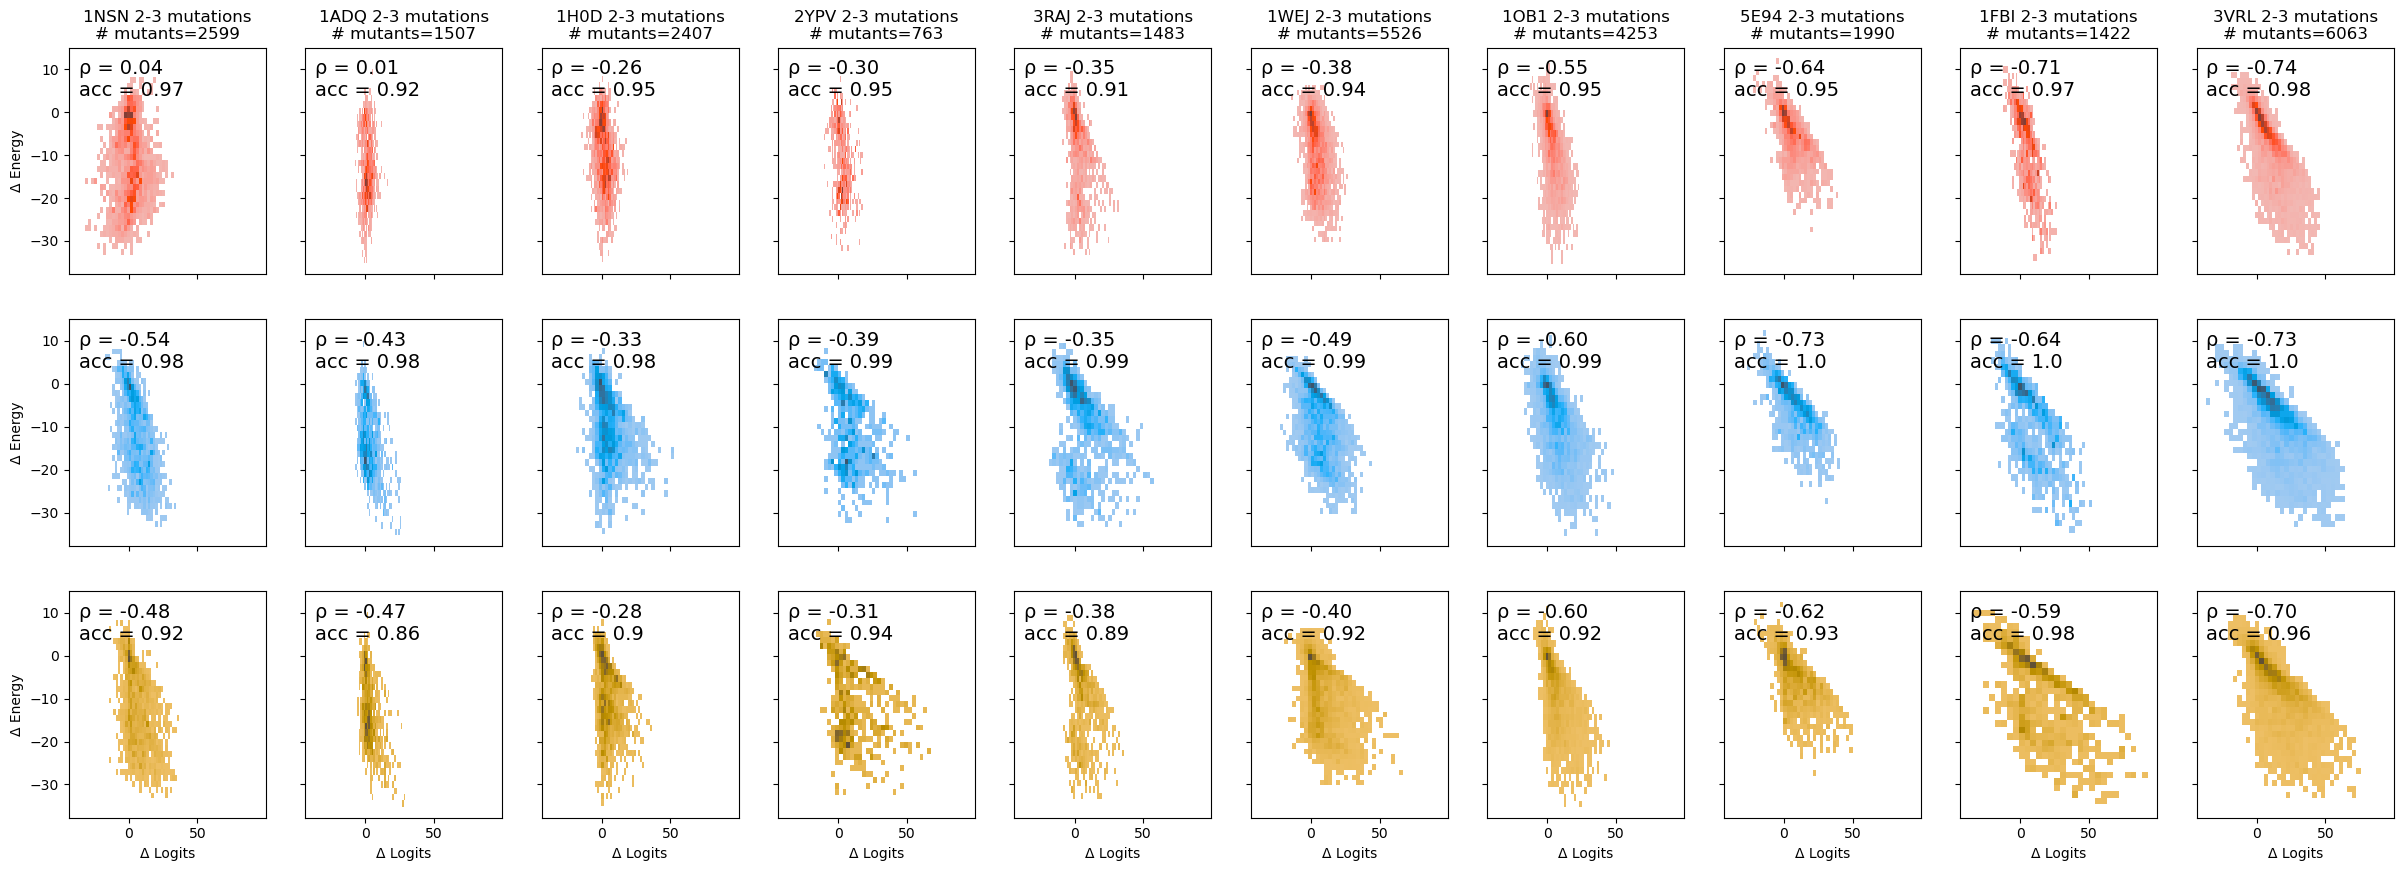

In [132]:
fig, ax = plt.subplots(3,10, figsize=(30,10), sharex=True, sharey=True)
for j, ag in enumerate(order_dict.keys()):
    for i, task in enumerate(tasks):
        mut_ig = pd.read_csv(f'./mutant_igs/{ag}_{task}_2-3mut_igs.csv')
        color = get_color(task)
        sns.histplot(mut_ig, x = 'dLogits', y='dEnergy',color=color, ax=ax[i,j], bins=30)
        #ax[i,j].hist2d(x = mut_ig['dLogits'], y=mut_ig['dEnergy'],cmap=color, bins=50)
        #sns.scatterplot(mut_ig, x = 'dLogits', y='dEnergy', s=20, color=color, ax=ax[i,j])#linewidth=0.02
        acc = perf_df[(perf_df['train_ag'] == ag) & (perf_df['train_task'] == task) & (perf_df['test_task'] == task)]['acc'].max()
        acc = round(acc,2)
        r = np.corrcoef(mut_ig['dLogits'].values, mut_ig['dEnergy'].values)[0,1]
        n = len(mut_ig)
       #insert text to each sublot
        ax[i,j].text(0.05, 0.95, 'ρ = {:.2f}\nacc = {acc}'.format(r, acc=acc), transform=ax[i,j].transAxes, fontsize=14, verticalalignment='top')
        ax[i,0].set_ylabel(f'{task}\n\n dEnergy')
        #rename x-axis
        ax[2,j].set_xlabel('Δ Logits')
        #rename y-axis
        ax[i,0].set_ylabel('Δ Energy')
    ax[0,j].set_title(f'{ag} 2-3 mutations\n# mutants={n}')

In [137]:
order_dict.keys()

dict_keys(['1NSN', '1ADQ', '1H0D', '2YPV', '3RAJ', '1WEJ', '1OB1', '5E94', '1FBI', '3VRL'])

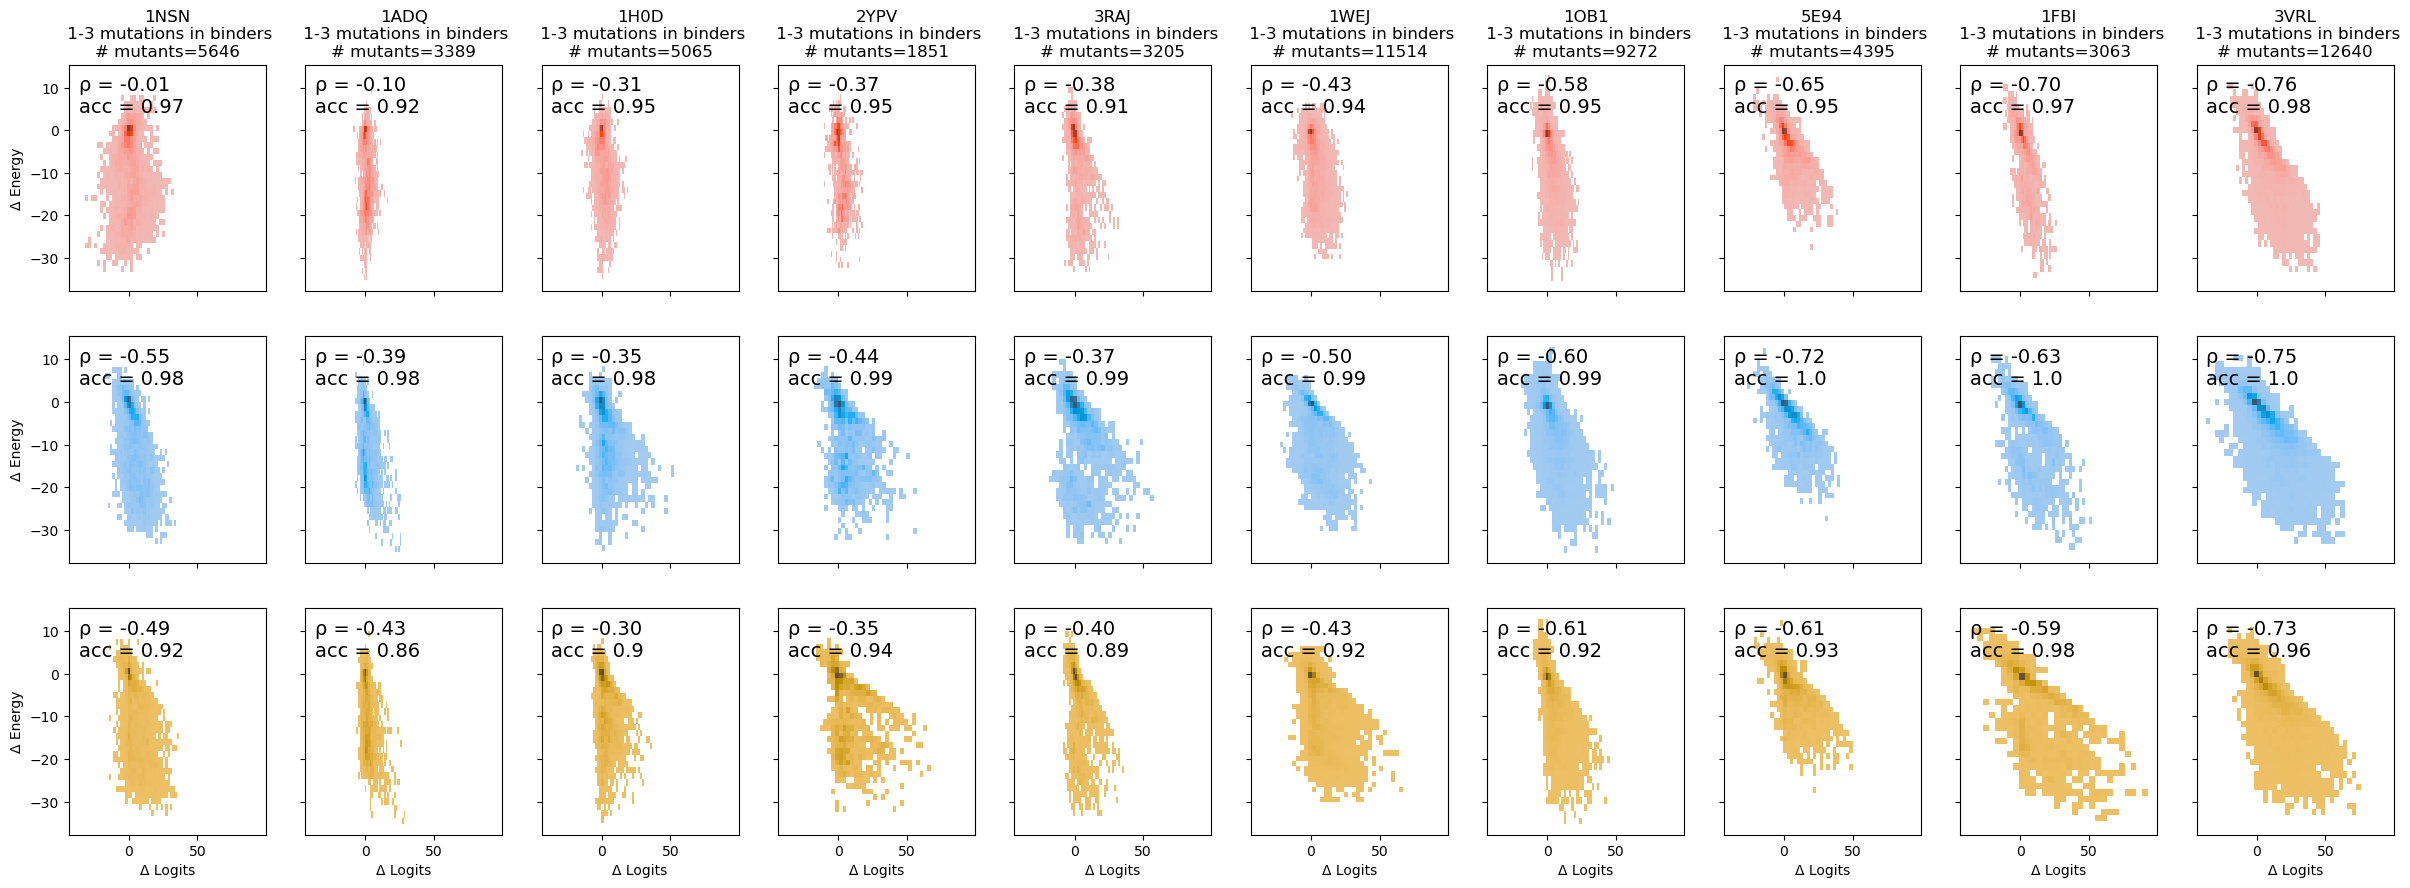

In [135]:
#return here 3
fig, ax = plt.subplots(3,10, figsize=(30,10), sharex=True, sharey=True)
for j, ag in enumerate(order_dict.keys()):
    for i, task in enumerate(tasks):
        mut_ig1 = pd.read_csv(f'./mutant_igs/{ag}_{task}_mut_igs.csv')
        mut_ig23 = pd.read_csv(f'./mutant_igs/{ag}_{task}_2-3mut_igs.csv')
        mut_ig = pd.concat([mut_ig1, mut_ig23], axis=0)
        color = get_color(task)
        sns.histplot(mut_ig, x = 'dLogits', y='dEnergy',color=color, ax=ax[i,j], bins=30)
        #ax[i,j].hist2d(x = mut_ig['dLogits'], y=mut_ig['dEnergy'],cmap=color, bins=50)
        #sns.scatterplot(mut_ig, x = 'dLogits', y='dEnergy', s=20, color=color, ax=ax[i,j])#linewidth=0.02
        acc = perf_df[(perf_df['train_ag'] == ag) & (perf_df['train_task'] == task) & (perf_df['test_task'] == task)]['acc'].max()
        acc = round(acc,2)
        r = np.corrcoef(mut_ig['dLogits'].values, mut_ig['dEnergy'].values)[0,1]
        n = len(mut_ig)
       #insert text to each sublot
        ax[i,j].text(0.05, 0.95, 'ρ = {:.2f}\nacc = {acc}'.format(r, acc=acc), transform=ax[i,j].transAxes, fontsize=14, verticalalignment='top')
        ax[i,0].set_ylabel(f'{task}\n\n dEnergy')
        #rename x-axis
        ax[2,j].set_xlabel('Δ Logits')
        #rename y-axis
        ax[i,0].set_ylabel('Δ Energy')
    ax[0,j].set_title(f'{ag}\n 1-3 mutations in binders\n# mutants={n}')

In [36]:
#as Eugen's in section 2
mut_eng_attr_r = []
for j, ag in enumerate(order_dict.keys()):
    for i, task in enumerate(tasks):
        mut_ig = pd.read_csv(f'./mutant_igs/{ag}_{task}_mut_igs.csv')
        r = np.corrcoef(mut_ig['posn delta IG'].values, mut_ig['dEnergy'].values)[0,1]
        mut_eng_attr_r.append([ag, task, r])


In [41]:
cmap_ag = {'1FBI': '#008080',
 '3VRL': '#FFA07A',
 '2YPV': '#000080',
 '5E94': '#FFD700',
 '1WEJ': '#228B22',
 '1OB1': '#FF69B4',
 '1NSN': '#800080',
 '1H0D': '#FF6347',
 '3RAJ': '#00FF00',
 '1ADQ': '#FF1493'}

<AxesSubplot:xlabel='task', ylabel='r'>

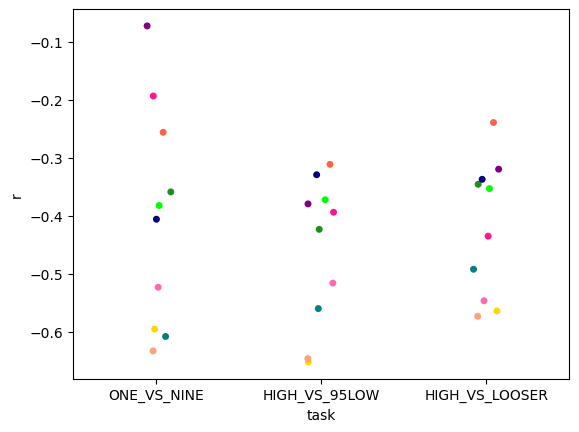

In [42]:
df_mut_eng_attr_r = pd.DataFrame(mut_eng_attr_r, columns = ['ag', 'task', 'r'])
sns.stripplot(x='task', y='r', hue='ag', data=df_mut_eng_attr_r, legend=False, palette=cmap_ag)

In [43]:
#df_mut_eng_attr_r.sort_values(by=['r'], )
#sort r values in df_mut_eng_attr_r inside each task group
df_mut_eng_attr_r.groupby('task').apply(lambda x: x.sort_values(by=['r'], ascending=False))

ag            task         r
task                                             
HIGH_VS_95LOW  7   1H0D   HIGH_VS_95LOW -0.311687
               16  2YPV   HIGH_VS_95LOW -0.329698
               13  3RAJ   HIGH_VS_95LOW -0.372801
               1   1NSN   HIGH_VS_95LOW -0.379915
               4   1ADQ   HIGH_VS_95LOW -0.394285
               10  1WEJ   HIGH_VS_95LOW -0.423790
               19  1OB1   HIGH_VS_95LOW -0.516425
               25  1FBI   HIGH_VS_95LOW -0.560352
               28  3VRL   HIGH_VS_95LOW -0.646555
               22  5E94   HIGH_VS_95LOW -0.652306
HIGH_VS_LOOSER 8   1H0D  HIGH_VS_LOOSER -0.239629
               2   1NSN  HIGH_VS_LOOSER -0.320074
               17  2YPV  HIGH_VS_LOOSER -0.337572
               11  1WEJ  HIGH_VS_LOOSER -0.346108
               14  3RAJ  HIGH_VS_LOOSER -0.353485
               5   1ADQ  HIGH_VS_LOOSER -0.435481
               26  1FBI  HIGH_VS_LOOSER -0.492553
               20  1OB1  HIGH_VS_LOOSER -0.546870
               23  5E94  HIGH_VS_LOOSER -0.564350
               29  3VRL  HIGH_VS_LOOSER -0.573656
ONE_VS_NINE    0   1NSN     ONE_VS_NINE -0.073136
               3   1ADQ     ONE_VS_NINE -0.193938
               6   1H0D     ONE_VS_NINE -0.256544
               9   1WEJ     ONE_VS_NINE -0.359202
               12  3RAJ     ONE_VS_NINE -0.382673
               15  2YPV     ONE_VS_NINE -0.406340
               18  1OB1     ONE_VS_NINE -0.523576
               21  5E94     ONE_VS_NINE -0.595785
               24  1FBI     ONE_VS_NINE -0.608426
               27  3VRL     ONE_VS_NINE -0.633287

In [34]:
for j, ag in enumerate(order_dict.keys()):
    for i, task in enumerate(tasks):
        mut_ig = pd.read_csv(f'./mutant_igs/{ag}_{task}_mut_igs.csv')
        break
    break

In [37]:
mut_ig['original Slide'].value_counts()

CAKLSNSFAYW    200
CARLDDGLDVW    200
CARRELGLLAY    185
CALISQRIYFD    170
CTGTDFAWFAY    163
IVGLRRGFDYW    159
CATLGSNWDYF    152
SLRDYDLAWFA    150
QLLLRGNWFAY    148
QLRLPTRFDYW    147
DLLYDYGVLAY    147
RLDDYDLAWFA    145
YYDYDLSYFDY    145
SLLLRSEWFAY    141
YYDYDLGFFAY    140
ARLFGPQLLWY    138
EVIVSLNWDWF    122
CTREEIGYWYF    120
IKTIDFPLGYF    117
ALLLRGSIVAY     84
GLYDYDLSWFA     74
Name: original Slide, dtype: int64

In [39]:
mut_ig

ID_slide_Variant           CDR3   Best        Slide  Energy  \
0     M_H16405617_00a_1m_184_00a  DALISQRIYFDYW   True  DALISQRIYFD  -87.40   
1     M_H16405617_00a_1m_185_00a  EALISQRIYFDYW   True  EALISQRIYFD  -87.62   
2     M_H16405617_00a_1m_186_00a  FALISQRIYFDYW  False  FALISQRIYFD  -79.38   
3     M_H16405617_00a_1m_187_00a  GALISQRIYFDYW   True  GALISQRIYFD  -87.48   
4     M_H16405617_00a_1m_188_00a  HALISQRIYFDYW   True  HALISQRIYFD  -88.04   
...                          ...            ...    ...          ...     ...   
3042    M_H1916675_00a_1m_71_00a   CARRELGLLARW   True  CARRELGLLAR  -89.91   
3043    M_H1916675_00a_1m_72_00a   CARRELGLLASW   True  CARRELGLLAS  -90.26   
3044    M_H1916675_00a_1m_73_00a   CARRELGLLATW   True  CARRELGLLAT  -91.03   
3045    M_H1916675_00a_1m_74_00a   CARRELGLLAVW  False  CARRELGLLAV  -73.81   
3046    M_H1916675_00a_1m_75_00a   CARRELGLLAWW  False  CARRELGLLAW  -73.85   

              Structure  n_mut            ID original Slide  \
0     149860-DDSLRSRRDR    1.0  16405617_00a    CALISQRIYFD   
1     149860-DDSLRSRRDR    1.0  16405617_00a    CALISQRIYFD   
2     145760-LRSUURURSS    1.0  16405617_00a    CALISQRIYFD   
3     149860-DDSLRSRRDR    1.0  16405617_00a    CALISQRIYFD   
4     149860-DDSLRSRRDR    1.0  16405617_00a    CALISQRIYFD   
...                 ...    ...           ...            ...   
3042  137504-LSUSURSSSD    1.0   1916675_00a    CARRELGLLAY   
3043  137504-LSUSURSSSD    1.0   1916675_00a    CARRELGLLAY   
3044  137504-LSUSURSSSD    1.0   1916675_00a    CARRELGLLAY   
3045  149857-LRDURRSSRR    1.0   1916675_00a    CARRELGLLAY   
3046  149857-LRDURRSSRR    1.0   1916675_00a    CARRELGLLAY   

                                                 IG org  Energy org  \
0     [-0.3216683103788171, -0.4388124307168045, 0.7...      -90.00   
1     [-0.3216683103788171, -0.4388124307168045, 0.7...      -90.00   
2     [-0.3216683103788171, -0.4388124307168045, 0.7...      -90.00   
3     [-0.3216683103788171, -0.4388124307168045, 0.7...      -90.00   
4     [-0.3216683103788171, -0.4388124307168045, 0.7...      -90.00   
...                                                 ...         ...   
3042  [-0.18380864208918946, 0.05345282616930107, 0....      -93.54   
3043  [-0.18380864208918946, 0.05345282616930107, 0....      -93.54   
3044  [-0.18380864208918946, 0.05345282616930107, 0....      -93.54   
3045  [-0.18380864208918946, 0.05345282616930107, 0....      -93.54   
3046  [-0.18380864208918946, 0.05345282616930107, 0....      -93.54   

                                                 mut OH  \
0     [[array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0...   
1     [[array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0...   
2     [[array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0...   
3     [[array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0...   
4     [[array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0...   
...                                                 ...   
3042  [[array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0...   
3043  [[array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0...   
3044  [[array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0...   
3045  [[array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0...   
3046  [[array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0...   

                                                 IG mut  degree wt  \
0     [0.27619745269213264, -0.33105368968425186, 0....          2   
1     [0.6672838669337665, -0.035336315410137924, -0...          2   
2     [-0.5229832484418615, -0.281850537035644, 0.52...          2   
3     [0.03715944906626476, -0.4446212618716846, 0.2...          2   
4     [-0.023841038299134944, -0.4579546729825123, 0...          2   
...                                                 ...        ...   
3042  [-0.21207298349520265, 0.022754603494377745, 0...          2   
3043  [-0.10810106304775838, 0.026349158003459768, 0...          2   
3044  [-0.13552480473123527, 0.02592286325387, 0.080...          2   
3045  [-0.5995143640209428, 0.10926009296358076,

In [ ]:
#todo not ig but logits
#for tha I have to run the model on the mutants and original slide

In [ ]:
#find model for each seq
#run model for each seq, get logits, calculate difference 

In [67]:
mut_ig['original Slide'].apply(lambda x: )

ID_slide_Variant           CDR3   Best        Slide  Energy  \
0     M_H16405617_00a_1m_184_00a  DALISQRIYFDYW   True  DALISQRIYFD  -87.40   
1     M_H16405617_00a_1m_185_00a  EALISQRIYFDYW   True  EALISQRIYFD  -87.62   
2     M_H16405617_00a_1m_186_00a  FALISQRIYFDYW  False  FALISQRIYFD  -79.38   
3     M_H16405617_00a_1m_187_00a  GALISQRIYFDYW   True  GALISQRIYFD  -87.48   
4     M_H16405617_00a_1m_188_00a  HALISQRIYFDYW   True  HALISQRIYFD  -88.04   
...                          ...            ...    ...          ...     ...   
3042    M_H1916675_00a_1m_71_00a   CARRELGLLARW   True  CARRELGLLAR  -89.91   
3043    M_H1916675_00a_1m_72_00a   CARRELGLLASW   True  CARRELGLLAS  -90.26   
3044    M_H1916675_00a_1m_73_00a   CARRELGLLATW   True  CARRELGLLAT  -91.03   
3045    M_H1916675_00a_1m_74_00a   CARRELGLLAVW  False  CARRELGLLAV  -73.81   
3046    M_H1916675_00a_1m_75_00a   CARRELGLLAWW  False  CARRELGLLAW  -73.85   

              Structure  n_mut            ID original Slide  \
0     149860-DDSLRSRRDR    1.0  16405617_00a    CALISQRIYFD   
1     149860-DDSLRSRRDR    1.0  16405617_00a    CALISQRIYFD   
2     145760-LRSUURURSS    1.0  16405617_00a    CALISQRIYFD   
3     149860-DDSLRSRRDR    1.0  16405617_00a    CALISQRIYFD   
4     149860-DDSLRSRRDR    1.0  16405617_00a    CALISQRIYFD   
...                 ...    ...           ...            ...   
3042  137504-LSUSURSSSD    1.0   1916675_00a    CARRELGLLAY   
3043  137504-LSUSURSSSD    1.0   1916675_00a    CARRELGLLAY   
3044  137504-LSUSURSSSD    1.0   1916675_00a    CARRELGLLAY   
3045  149857-LRDURRSSRR    1.0   1916675_00a    CARRELGLLAY   
3046  149857-LRDURRSSRR    1.0   1916675_00a    CARRELGLLAY   

                                                 IG org  Energy org  \
0     [-0.3216683103788171, -0.4388124307168045, 0.7...      -90.00   
1     [-0.3216683103788171, -0.4388124307168045, 0.7...      -90.00   
2     [-0.3216683103788171, -0.4388124307168045, 0.7...      -90.00   
3     [-0.3216683103788171, -0.4388124307168045, 0.7...      -90.00   
4     [-0.3216683103788171, -0.4388124307168045, 0.7...      -90.00   
...                                                 ...         ...   
3042  [-0.18380864208918946, 0.05345282616930107, 0....      -93.54   
3043  [-0.18380864208918946, 0.05345282616930107, 0....      -93.54   
3044  [-0.18380864208918946, 0.05345282616930107, 0....      -93.54   
3045  [-0.18380864208918946, 0.05345282616930107, 0....      -93.54   
3046  [-0.18380864208918946, 0.05345282616930107, 0....      -93.54   

                                                 mut OH  \
0     [[array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0...   
1     [[array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0...   
2     [[array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0...   
3     [[array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0...   
4     [[array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0...   
...                                                 ...   
3042  [[array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0...   
3043  [[array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0...   
3044  [[array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0...   
3045  [[array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0...   
3046  [[array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0...   

                                                 IG mut  degree wt  \
0     [0.27619745269213264, -0.33105368968425186, 0....          2   
1     [0.6672838669337665, -0.035336315410137924, -0...          2   
2     [-0.5229832484418615, -0.281850537035644, 0.52...          2   
3     [0.03715944906626476, -0.4446212618716846, 0.2...          2   
4     [-0.023841038299134944, -0.4579546729825123, 0...          2   
...                                                 ...        ...   
3042  [-0.21207298349520265, 0.022754603494377745, 0...          2   
3043  [-0.10810106304775838, 0.026349158003459768, 0...          2   
3044  [-0.13552480473123527, 0.02592286325387, 0.080...          2   
3045  [-0.5995143640209428, 0.10926009296358076,

In [72]:
mut_ig['mut OH'].iloc[0]

'[[array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,\n       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,\n       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,\n       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,\n       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,\n       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,\n       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,\n       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,\n       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,\n       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,\n       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,\n       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,\n       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]]'

In [ ]:
mut_ig['mut OH'].apply(lambda x: eval(x)) 

## Trying to group by originak slide

In [131]:
mps_device = torch.device("mps")
for ag in tqdm(config.ANTIGENS, desc='Antigens'):
    for task in tasks:
        mut_ig = pd.read_csv(f'./mutant_igs/{ag}_{task}_2-3mut_igs.csv')
        mut_ig['org OH'] = mut_ig['original Slide'].apply(lambda x: [[onehot_encode(x)]])
        mut_ig['mut OH'] = mut_ig['Slide'].apply(lambda x: [[onehot_encode(x)]])
        seed_id, split_id = 0, 42
        model_path = f"./torch_models/Frozen_MiniAbsolut_ML/{tasks_dict[task]}/seed_{seed_id}/split_{split_id}/{task_template[task].format(ag=ag)}/swa_model/data/model.pth"
        model = torch.load(model_path, map_location=torch.device("cpu"))

        X_org = torch.tensor(mut_ig['org OH'].tolist(), dtype=torch.float32).to("cpu")
        X_mut = torch.tensor(mut_ig['mut OH'].tolist(), dtype=torch.float32).to("cpu")
        y_pred_org, logits_org = model(X_org, return_logits = True)
        y_pred_mut, logits_mut = model(X_mut, return_logits = True)
        mut_ig['dLogits'] = logits_org.cpu().detach().numpy().reshape(-1) - logits_mut.cpu().detach().numpy().reshape(-1)
        mut_ig.to_csv(f'./mutant_igs/{ag}_{task}_2-3mut_igs.csv', index=False)


Antigens: 100%|██████████| 10/10 [01:33<00:00,  9.31s/it]


In [ ]:
f'./mutant_igs/{ag}_{task}_mut_igs.csv'

In [129]:
add_dLogits(f'./mutant_igs/{ag}_{task}_2-3mut_igs.csv')

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_9531/959981192.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1664817724064/work/torch/csrc/utils/tensor_new.cpp:204.)
  X_org = torch.tensor(mut_ig['org OH'].tolist(), dtype=torch.float32).to("cpu")


In [91]:
ag_order = [
        "1FBI",
        "3VRL",
        "2YPV",
        "5E94",
        "1WEJ",
        "1OB1",
        "1NSN",
        "1H0D",
        "3RAJ",
        "1ADQ",
    ]

In [5]:
task = 'ONE_VS_NINE'
order_dict = dict()
for j, ag in enumerate(config.ANTIGENS): 
    df_a = pd.read_csv(f'./mutant_igs/{ag}_{task}_mut_igs.csv')
    order_dict[ag] = np.corrcoef(df_a['dLogits'].values, df_a['dEnergy'].values)[0,1]


In [6]:
#order dict by values
order_dict = {k: v for k, v in sorted(order_dict.items(), key=lambda item: item[1], reverse=True)}

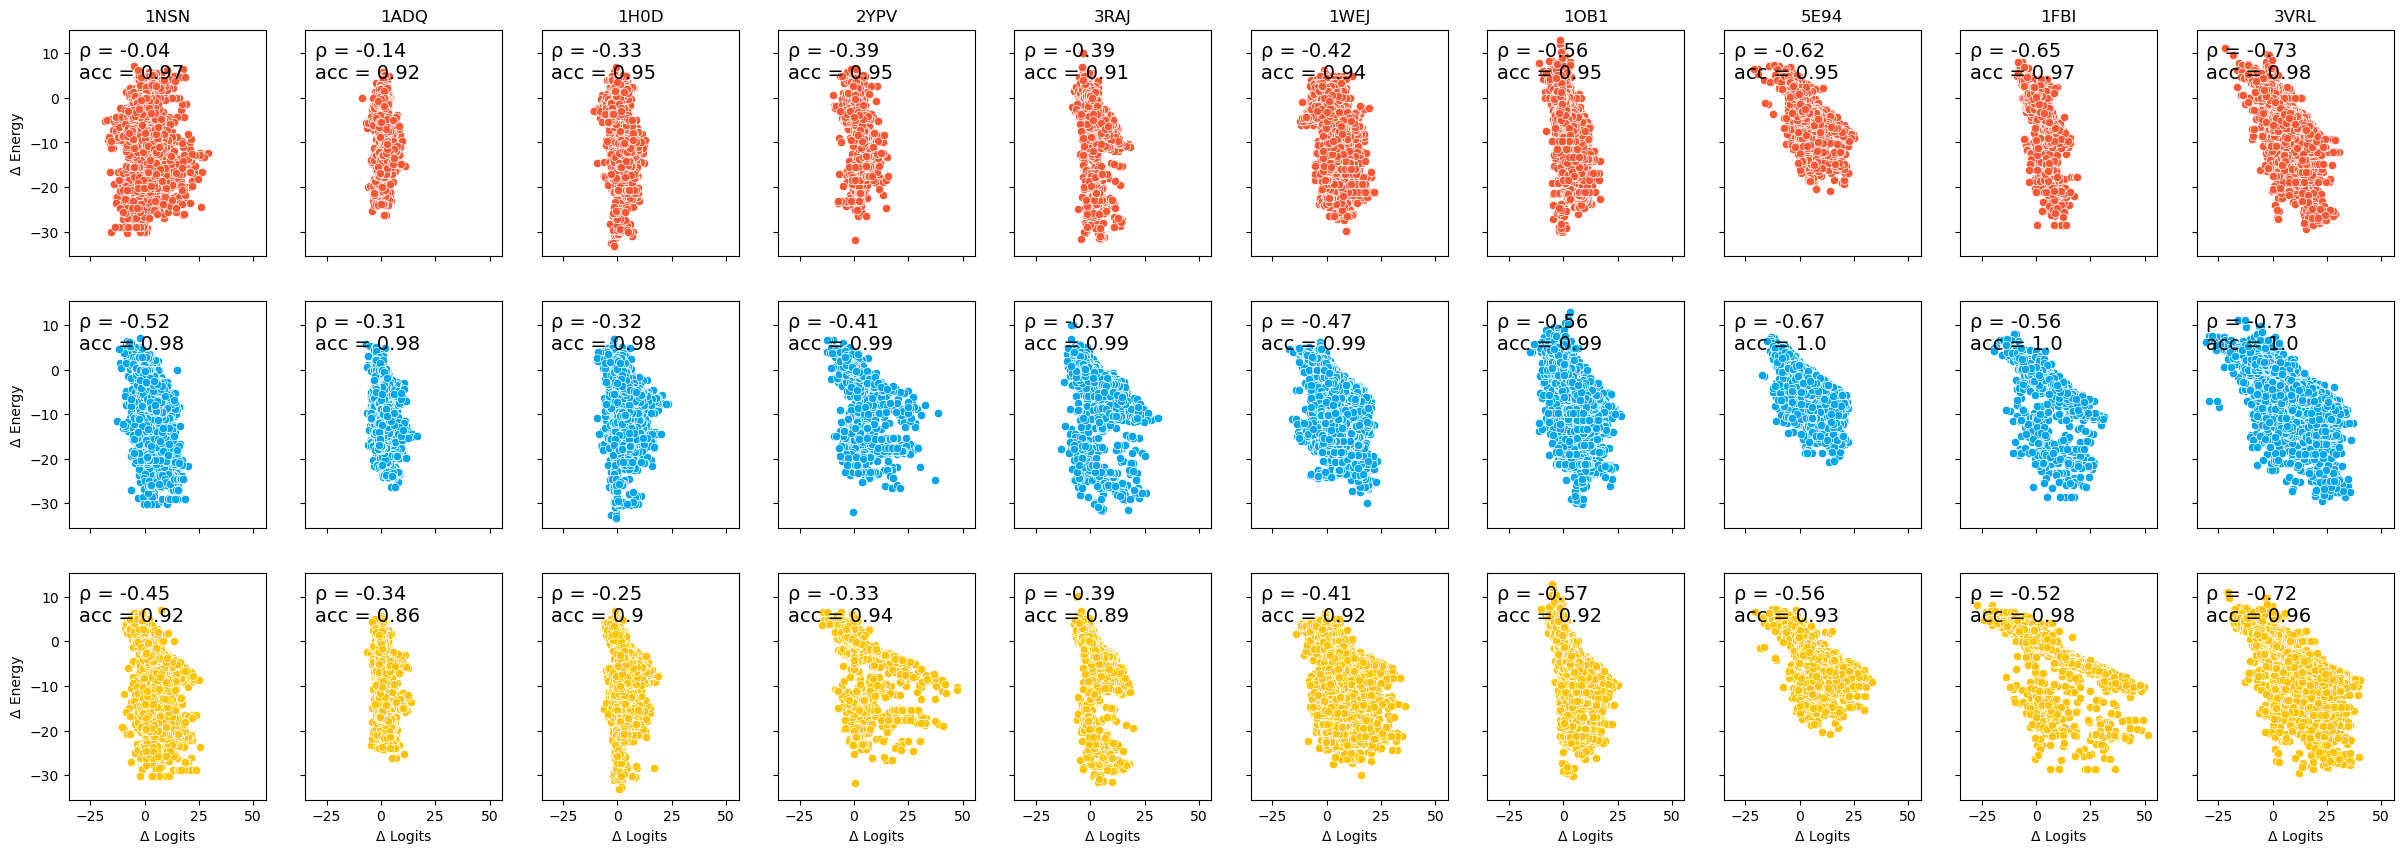

In [111]:
fig, ax = plt.subplots(3,10, figsize=(30,10), sharex=True, sharey=True)
#for j, ag in enumerate(ag_order):
for j, ag in enumerate(order_dict.keys()):
    for i, task in enumerate(tasks):
        mut_ig = pd.read_csv(f'./mutant_igs/{ag}_{task}_mut_igs.csv')
        color = get_color(task)
        sns.scatterplot(mut_ig, x = 'dLogits', y='dEnergy', color=color, ax=ax[i,j])#linewidth=0.02
        acc = perf_df[(perf_df['train_ag'] == ag) & (perf_df['train_task'] == task) & (perf_df['test_task'] == task)]['acc'].max()
        acc = round(acc,2)
       #insert text to each sublot
        ax[i,j].text(0.05, 0.95, 'ρ = {:.2f}\nacc = {acc}'.format(np.corrcoef(mut_ig['dLogits'].values, mut_ig['dEnergy'].values)[0,1], acc=acc), transform=ax[i,j].transAxes, fontsize=14, verticalalignment='top')
        ax[i,0].set_ylabel(f'{task}\n\n dEnergy')
        #rename x-axis
        ax[2,j].set_xlabel('Δ Logits')
        #rename y-axis
        ax[i,0].set_ylabel('Δ Energy')
    ax[0,j].set_title(ag)

<AxesSubplot:ylabel='Frequency'>

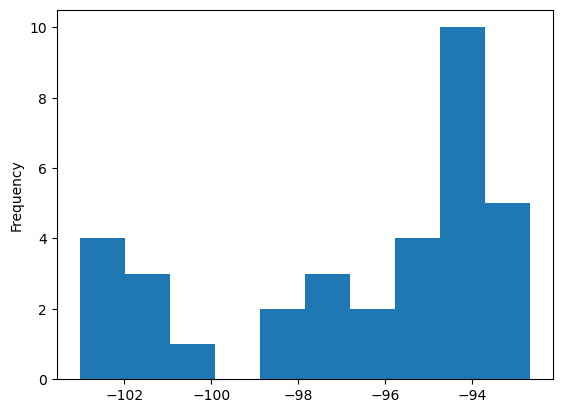

In [105]:
mut_ig.groupby('original Slide').mean()['Energy org'].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

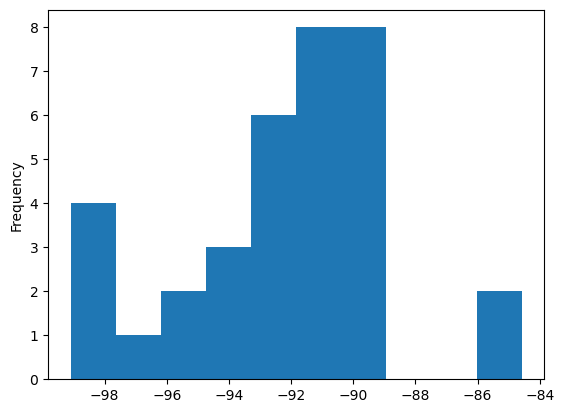

In [106]:
mut_ig.groupby('original Slide').mean()['Energy'].plot(kind='hist')

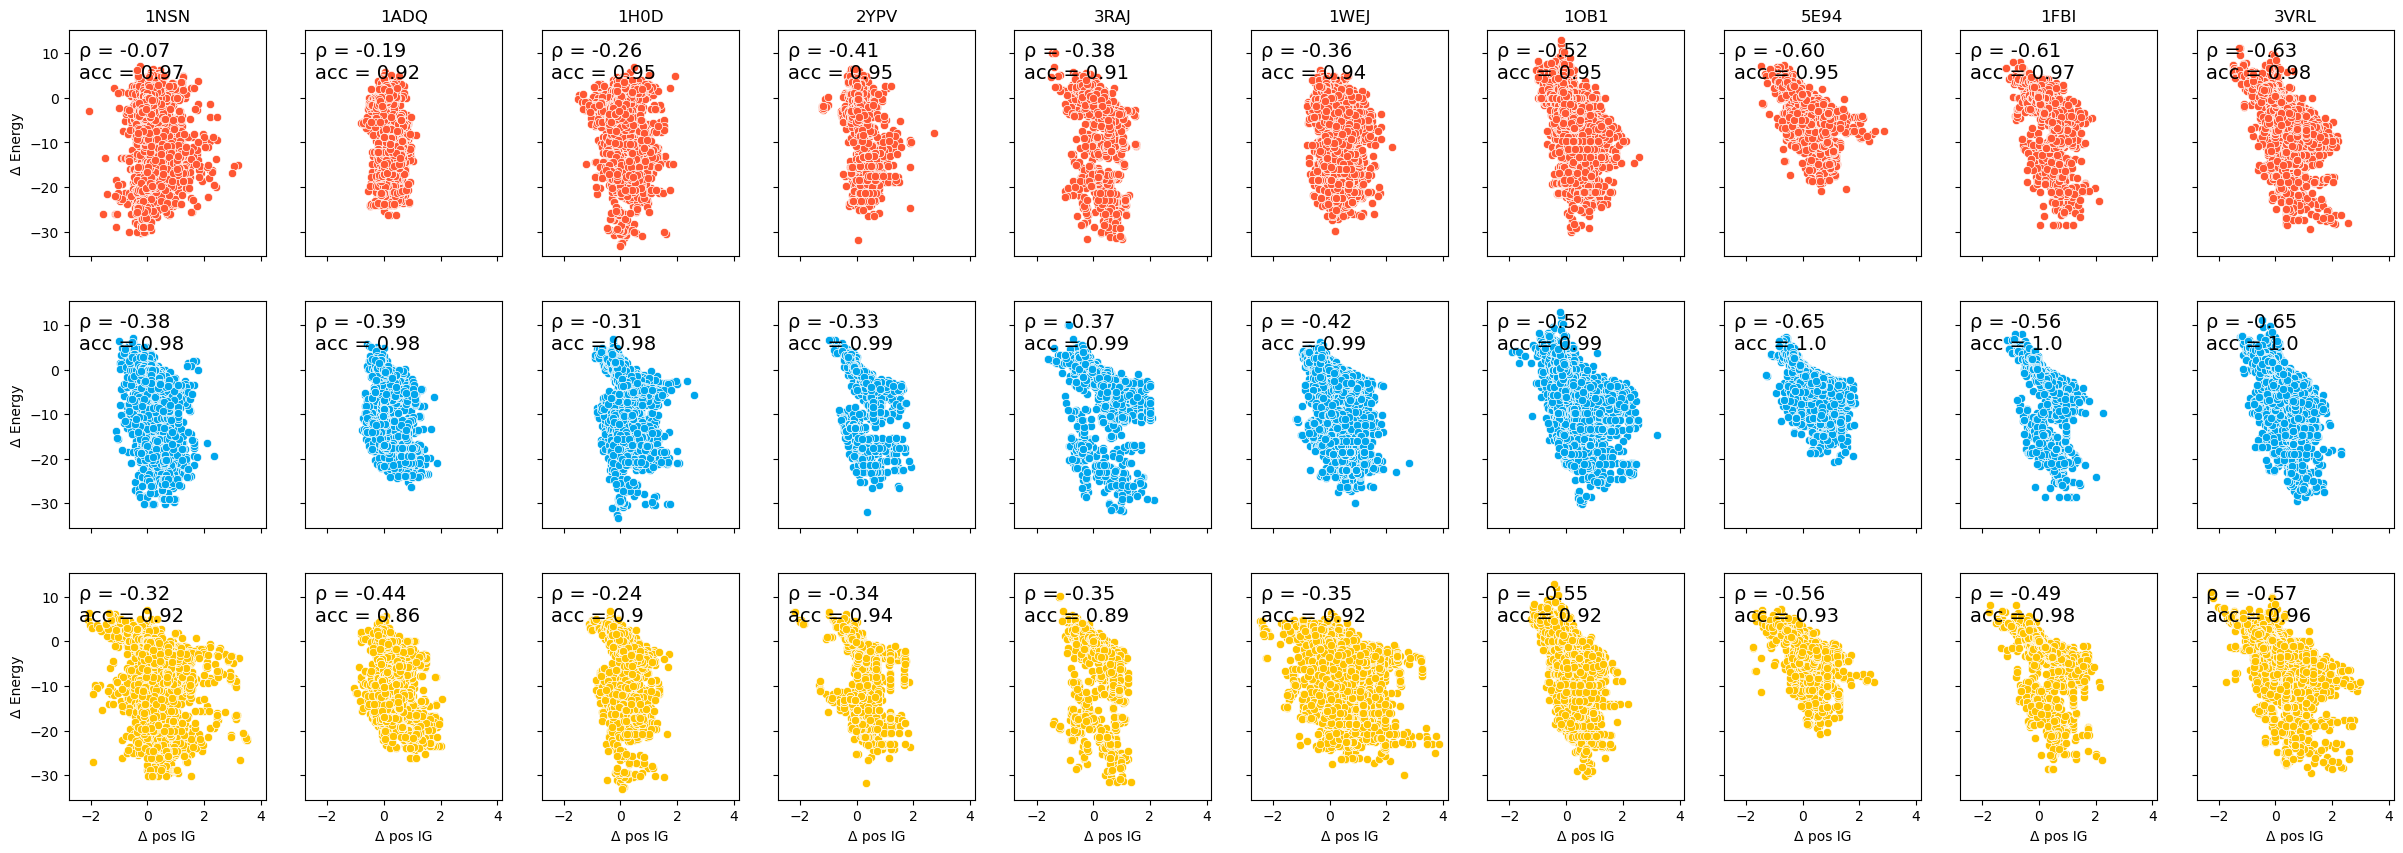

In [117]:
fig, ax = plt.subplots(3,10, figsize=(30,10), sharex=True, sharey=True)
#for j, ag in enumerate(ag_order):
for j, ag in enumerate(order_dict.keys()):
    for i, task in enumerate(tasks):
        mut_ig = pd.read_csv(f'./mutant_igs/{ag}_{task}_mut_igs.csv')
        color = get_color(task)
        sns.scatterplot(mut_ig, x = 'posn delta IG', y='dEnergy', color=color, ax=ax[i,j])#linewidth=0.02
        acc = perf_df[(perf_df['train_ag'] == ag) & (perf_df['train_task'] == task) & (perf_df['test_task'] == task)]['acc'].max()
        acc = round(acc,2)
       #insert text to each sublot
        ax[i,j].text(0.05, 0.95, 'ρ = {:.2f}\nacc = {acc}'.format(np.corrcoef(mut_ig['posn delta IG'].values, mut_ig['dEnergy'].values)[0,1], acc=acc), transform=ax[i,j].transAxes, fontsize=14, verticalalignment='top')
        ax[i,0].set_ylabel(f'{task}\n\n dEnergy')
        #rename x-axis
        ax[2,j].set_xlabel('Δ pos IG')
        #rename y-axis
        ax[i,0].set_ylabel('Δ Energy')
    ax[0,j].set_title(ag)

In [127]:
mut_ig.shape

(1882, 20)

original Slide
ARLRYDGYYFF    AxesSubplot(0.125,0.11;0.775x0.77)
AVLLLIPRYFD    AxesSubplot(0.125,0.11;0.775x0.77)
CACLLRQYYFD    AxesSubplot(0.125,0.11;0.775x0.77)
CARKEPPLLLL    AxesSubplot(0.125,0.11;0.775x0.77)
GALLLRNWYFD    AxesSubplot(0.125,0.11;0.775x0.77)
GGFLLEDWYFD    AxesSubplot(0.125,0.11;0.775x0.77)
GLFITTVSWYF    AxesSubplot(0.125,0.11;0.775x0.77)
GTMGLRQLAWF    AxesSubplot(0.125,0.11;0.775x0.77)
GVLWSRWYFDV    AxesSubplot(0.125,0.11;0.775x0.77)
LFPITRRYFDV    AxesSubplot(0.125,0.11;0.775x0.77)
MGWLLPNWYFD    AxesSubplot(0.125,0.11;0.775x0.77)
RSEFLLLVYYF    AxesSubplot(0.125,0.11;0.775x0.77)
TALLLRNWYFD    AxesSubplot(0.125,0.11;0.775x0.77)
YGVLWSRWYFD    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

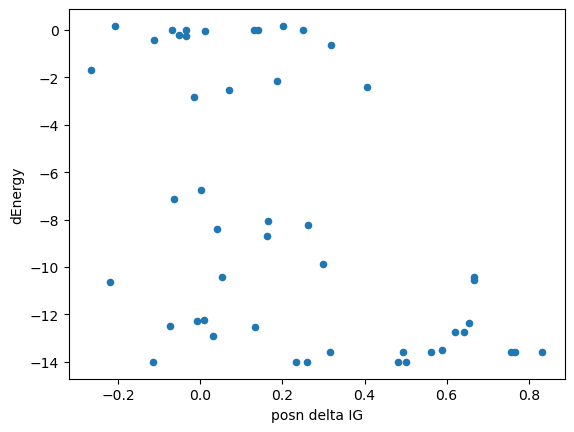

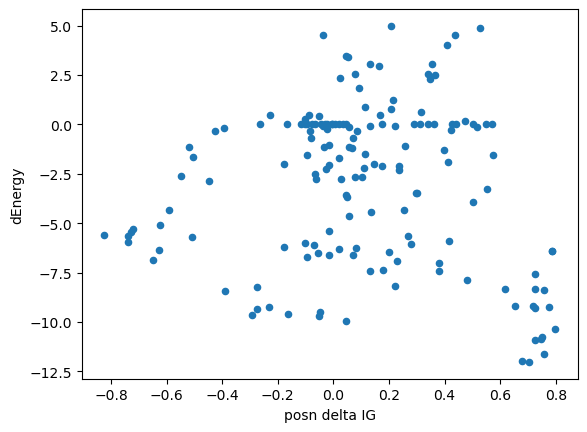

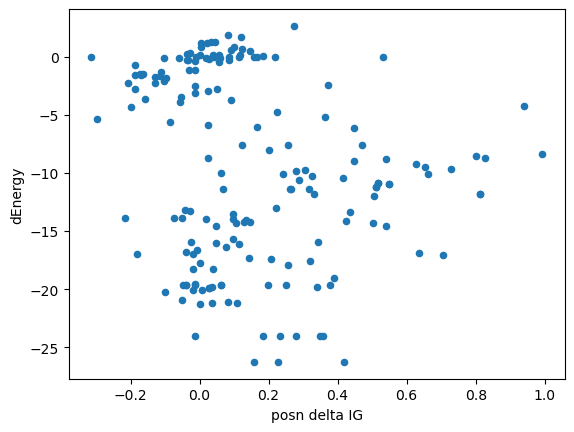

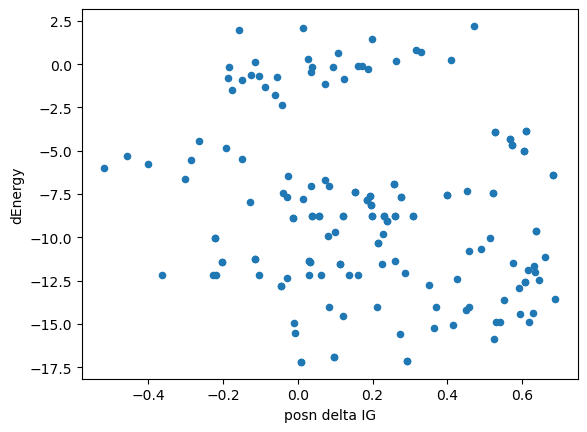

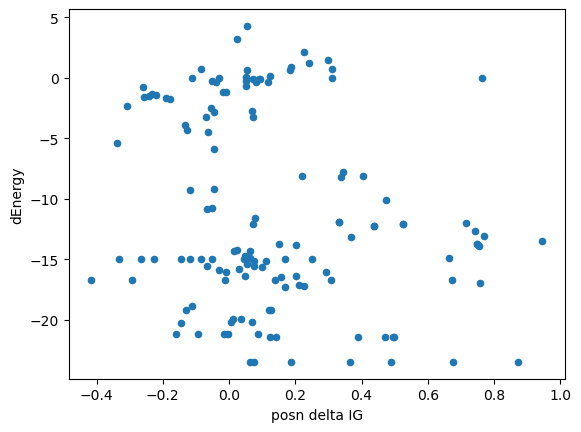

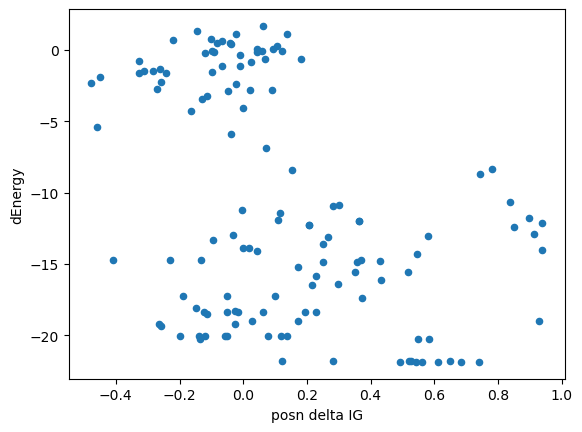

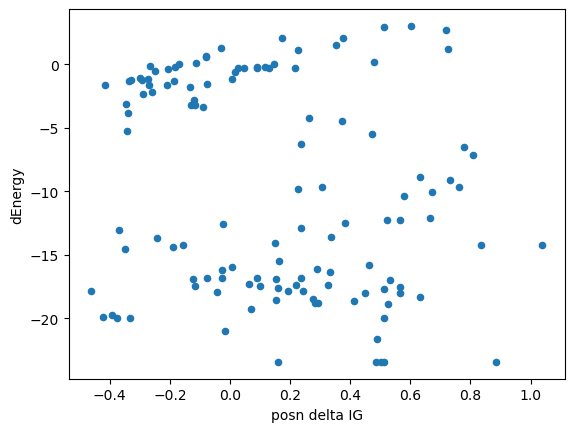

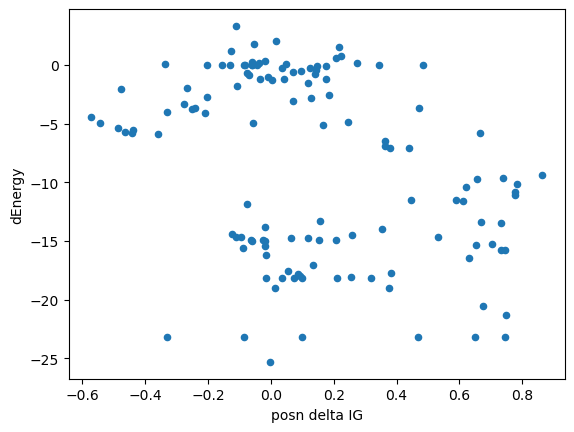

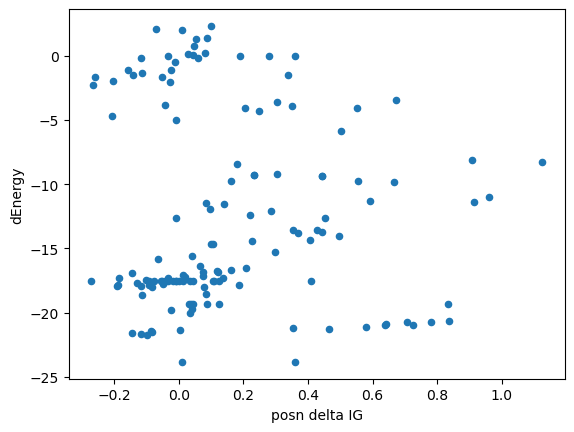

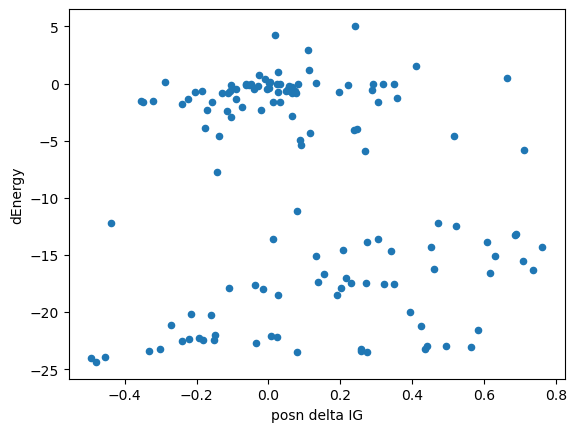

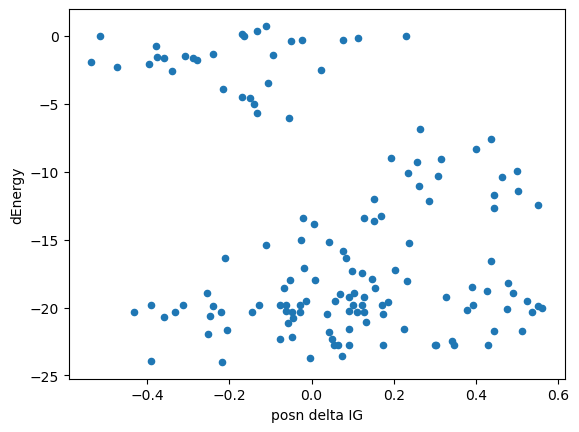

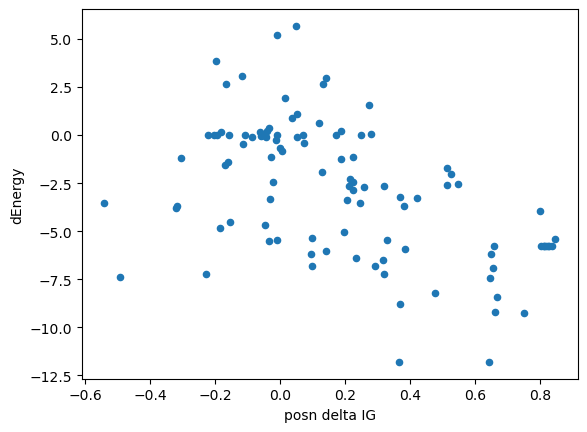

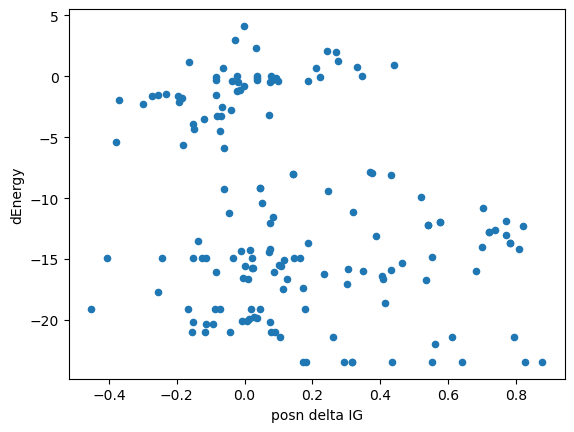

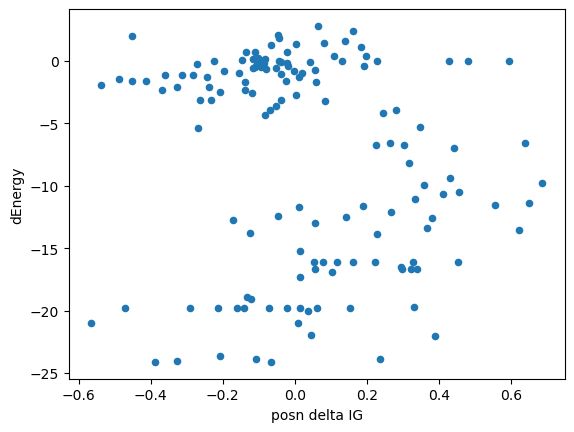

In [125]:
ag = '1ADQ'
task = 'ONE_VS_NINE'
mut_ig = pd.read_csv(f'./mutant_igs/{ag}_{task}_mut_igs.csv')
mut_ig.groupby('original Slide').plot(kind='scatter', x = 'posn delta IG', y='dEnergy')

In [121]:
mut_ig['original Slide'].unique()

array(['CATLITTVYYF', 'RDGLFYYVFAY', 'AIAYFNWYFDV', 'ARWILRFYWYF',
       'ELVLRFWYFDV', 'CTTLLRYCYAM', 'HESILHWYFDV', 'ATAYYSIYWYF'],
      dtype=object)

## Eugens request

In [30]:
#Inverse logistic function(y) = ln(y/(1-y))
def inverse_logistic_func(y):
    return np.log(y/(1-y))

In [59]:
mut_ig['log delta pos IG norm']

0      -0.918503
1       1.158662
2       0.913216
3       0.349545
4      -1.054969
          ...   
6572    0.892327
6573   -2.142866
6574   -1.268385
6575   -1.752333
6576   -0.491164
Name: log delta pos IG norm, Length: 6577, dtype: float64

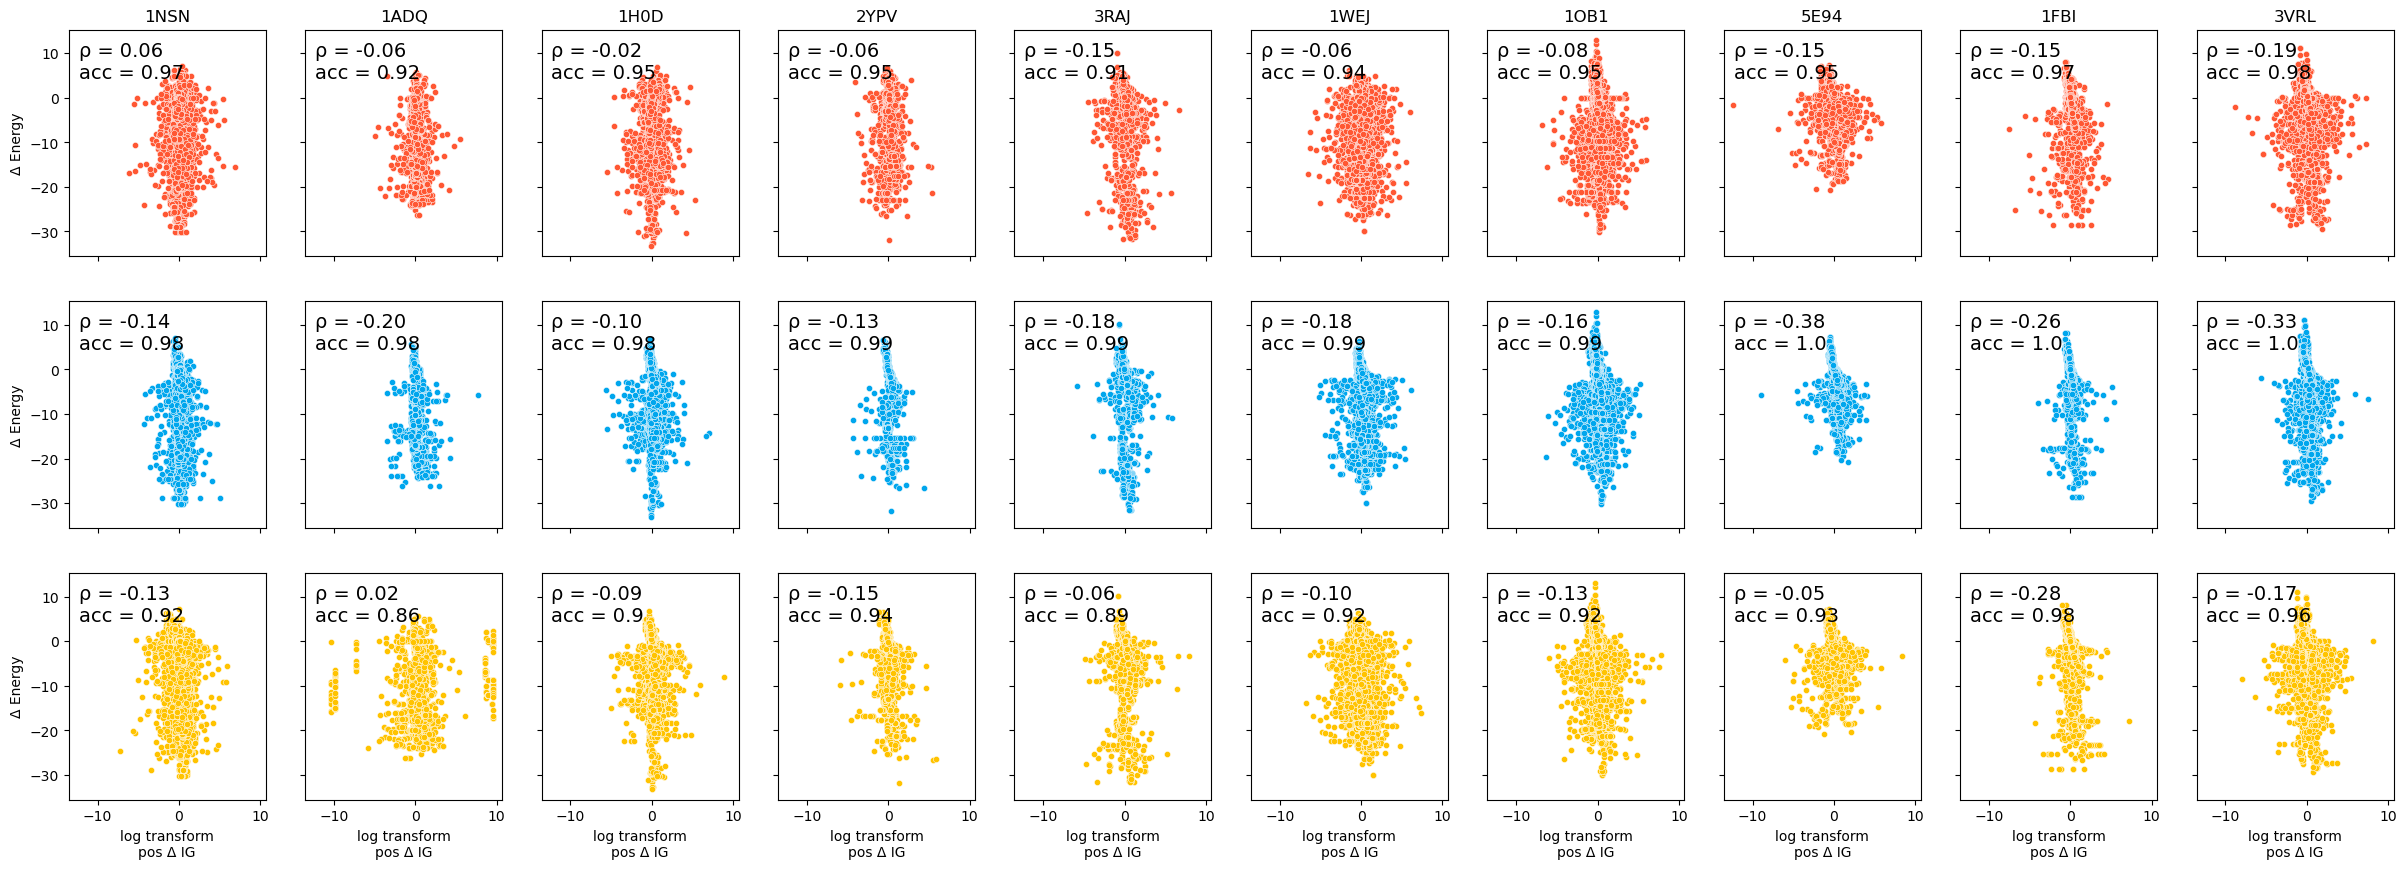

In [61]:
fig, ax = plt.subplots(3,10, figsize=(30,10), sharex=True, sharey=True)
for j, ag in enumerate(order_dict.keys()):
    for i, task in enumerate(tasks):
        mut_ig = pd.read_csv(f'./mutant_igs/{ag}_{task}_mut_igs.csv')
        color = get_color(task)
        mut_ig['IG org'] = mut_ig['IG org'].apply(lambda x: np.array(eval(x)))
        mut_ig['IG mut'] = mut_ig['IG mut'].apply(lambda x: np.array(eval(x)))
        mut_ig['org IG sum'] = mut_ig['IG org'].apply(lambda x: sum(x))
        mut_ig['mut IG sum'] = mut_ig['IG mut'].apply(lambda x: sum(x))
        mut_ig['delta pos IG norm'] = mut_ig['posn IG org']/mut_ig['org IG sum'] - mut_ig['posn IG mut']/ mut_ig['mut IG sum']
        mut_ig['log delta pos IG norm'] = mut_ig['delta pos IG norm'].apply(lambda x: np.sign(x) * np.log(1 + np.abs(x)))
        # np.sign(data) * np.log(1 + np.abs(data))
        sns.scatterplot(mut_ig, x = 'log delta pos IG norm', y='dEnergy', s=20, color=color, ax=ax[i,j])#linewidth=0.02
        acc = perf_df[(perf_df['train_ag'] == ag) & (perf_df['train_task'] == task) & (perf_df['test_task'] == task)]['acc'].max()
        acc = round(acc,2)
       #insert text to each sublot
        ax[i,j].text(0.05, 0.95, 'ρ = {:.2f}\nacc = {acc}'.format(np.corrcoef(mut_ig['log delta pos IG norm'].values, mut_ig['dEnergy'].values)[0,1], acc=acc), transform=ax[i,j].transAxes, fontsize=14, verticalalignment='top')
        ax[i,0].set_ylabel(f'{task}\n\n dEnergy')
        #rename x-axis
        ax[2,j].set_xlabel('log transform\npos Δ IG')
        #rename y-axis
        ax[i,0].set_ylabel('Δ Energy')
    ax[0,j].set_title(ag)
#fig.savefig('./figures/mut_igs_eng.svg')

In [23]:
pd.read_csv(f'./mutant_igs/3VRL_HIGH_VS_95LOW_mut_igs.csv')

ID_slide_Variant              CDR3   Best        Slide  \
0     SHH17238587_00a_1m_174_01a    CCRIGLLLRVFDYW  False  CRIGLLLRVFD   
1     SHH17238587_00a_1m_175_01a    CDRIGLLLRVFDYW  False  DRIGLLLRVFD   
2     SHH17238587_00a_1m_176_01a    CERIGLLLRVFDYW  False  ERIGLLLRVFD   
3     SHH17238587_00a_1m_177_01a    CHRIGLLLRVFDYW  False  HRIGLLLRVFD   
4     SHH17238587_00a_1m_178_01a    CIRIGLLLRVFDYW  False  IRIGLLLRVFD   
...                          ...               ...    ...          ...   
6572    H_H1698108_05a_1m_66_01a  CARRCWLLLGWNFDVW  False  ARRCWLLLGWN   
6573    H_H1698108_05a_1m_67_01a  CARRCWLLLGWRFDVW  False  ARRCWLLLGWR   
6574    H_H1698108_05a_1m_68_01a  CARRCWLLLGWSFDVW  False  ARRCWLLLGWS   
6575    H_H1698108_05a_1m_69_01a  CARRCWLLLGWTFDVW  False  ARRCWLLLGWT   
6576    H_H1698108_05a_1m_70_01a  CARRCWLLLGWVFDVW  False  ARRCWLLLGWV   

      Energy          Structure  n_mut            ID original Slide  \
0     -98.73  137569-BDLRDDSLUR    1.0  17238587_00a    ARIGLLLRVFD   
1     -96.30  137569-BDLRDDSLUR    1.0  17238587_00a    ARIGLLLRVFD   
2     -96.49  137569-BDLRDDSLUR    1.0  17238587_00a    ARIGLLLRVFD   
3     -97.44  137569-BDLRDDSLUR    1.0  17238587_00a    ARIGLLLRVFD   
4     -99.94  137569-BDLRDDSLUR    1.0  17238587_00a    ARIGLLLRVFD   
...      ...                ...    ...           ...            ...   
6572  -91.08  137570-BSDLRDDSLU    1.0   1698108_05a    ARRCWLLLGWY   
6573  -91.31  137570-BSDLRDDSLU    1.0   1698108_05a    ARRCWLLLGWY   
6574  -91.34  137570-BSDLRDDSLU    1.0   1698108_05a    ARRCWLLLGWY   
6575  -92.64  137570-BSDLRDDSLU    1.0   1698108_05a    ARRCWLLLGWY   
6576  -98.80  137570-BSDLRDDSLU    1.0   1698108_05a    ARRCWLLLGWY   

                                                 IG org  Energy org  \
0     [-0.5796954004894784, -0.4293225205150958, 0.5...      -97.81   
1     [-0.5796954004894784, -0.4293225205150958, 0.5...      -97.81   
2     [-0.5796954004894784, -0.4293225205150958, 0.5...      -97.81   
3     [-0.5796954004894784, -0.4293225205150958, 0.5...      -97.81   
4     [-0.5796954004894784, -0.4293225205150958, 0.5...      -97.81   
...                                                 ...         ...   
6572  [-0.26448510340849357, -0.2470876239525555, -0...      -97.09   
6573  [-0.26448510340849357, -0.2470876239525555, -0...      -97.09   
6574  [-0.26448510340849357, -0.2470876239525555, -0...      -97.09   
6575  [-0.26448510340849357, -0.2470876239525555, -0...      -97.09   
6576  [-0.26448510340849357, -0.2470876239525555, -0...      -97.09   

                                                 mut OH  \
0     [[array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0...   
1     [[array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0...   
2     [[array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0...   
3     [[array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0...   
4     [[array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0...   
...                                                 ...   
6572  [[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0...   
6573  [[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0...   
6574  [[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0...   
6575  [[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0...   
6576  [[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0...   

                                                 IG mut  degree wt  \
0     [-0.13412480087700798, -0.29638825835654464, 0...          1   
1     [-1.2218775992348492, -0.5035213050148054, 0.6...          1   
2     [-0.9219891473587923, -0.34380472303681975, 0....          1   
3     [-0.5173165241410708, -0.4101467383173357, 0.5...          1   
4     [0.21023584153736663, -0.2003144562487584, 0.2...          1   
...                                                 ...        ...   
6572  [-0.2801325713901039, -0.26204600045953863, -0...          4   
6573  [-0.28980801633244563, -0.2728129639797911, -0...          4   
6574  [-0.3133614903030118, -0.3201380858011548, -0....          4   
6575  [-0.29

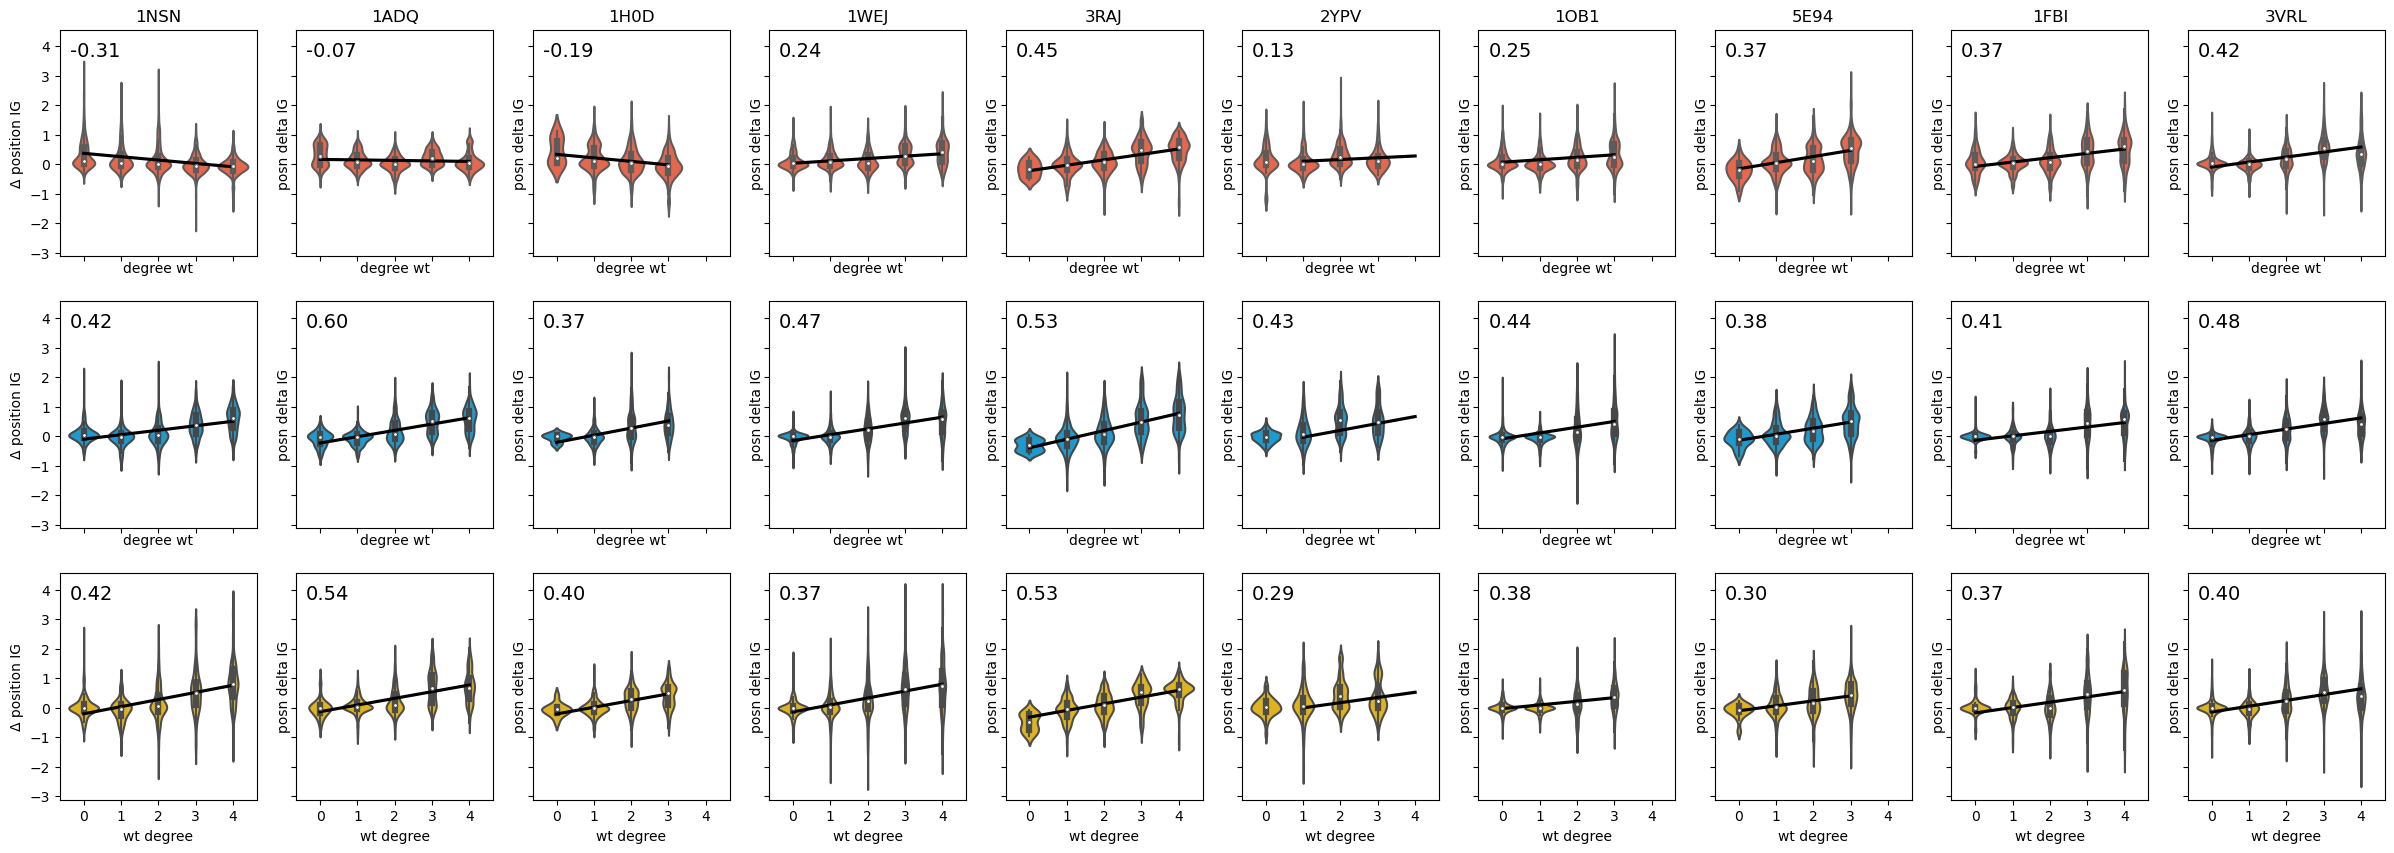

In [103]:
fig, ax = plt.subplots(3,10, figsize=(30,10), sharex=True, sharey=True)
for j, ag in enumerate(order_dict.keys()):
    for i, task in enumerate(tasks):
        mut_ig = pd.read_csv(f'./mutant_igs/{ag}_{task}_mut_igs.csv')
        color = get_color(task)
        sns.violinplot(mut_ig, y = 'posn delta IG', x='degree wt', s=20, color=color, ax=ax[i,j])#hue='degree wt'
        sns.regplot(mut_ig, x='degree wt', y='posn delta IG', scatter=False, color='black', ax=ax[i,j])
        ax[i,j].text(0.05, 0.95, '{:.2f}'.format(np.corrcoef(mut_ig['degree wt'].values, mut_ig['posn delta IG'].values)[0,1]), transform=ax[i,j].transAxes, fontsize=14, verticalalignment='top')

        #rename x-axis
        ax[2,j].set_xlabel('wt degree')
        #rename y-axis
        ax[i,0].set_ylabel('Δ position IG')
    ax[0,j].set_title(ag)


In [106]:
dfs = []
for ag in config.ANTIGENS:
    path_epi = glob.glob(f'../data/Slide_importance/{ag}_[A-Z]_Task4_Slice_ParaEpi.txt')[0]
    pos_degree_df = pd.read_csv(path_epi, sep='\t')
    pos_degree_df['antigen'] = ag
    dfs.append(pos_degree_df)
all_ag_imp_df = pd.concat(dfs)
all_ag_imp_df['aa_degrees'] = all_ag_imp_df.apply(lambda x: full_slide_degree(x.Slide, x.seqABParatope), axis=1)
all_ag_imp_df['degrees'] = all_ag_imp_df['aa_degrees'].apply(lambda d: list(map(lambda x: int(re.search('(\d)',x).group(1)),d)))

In [107]:
import warnings
warnings.filterwarnings("ignore")

In [109]:
order_dict.keys()

dict_keys(['1NSN', '1ADQ', '1H0D', '1WEJ', '3RAJ', '2YPV', '1OB1', '5E94', '1FBI', '3VRL'])

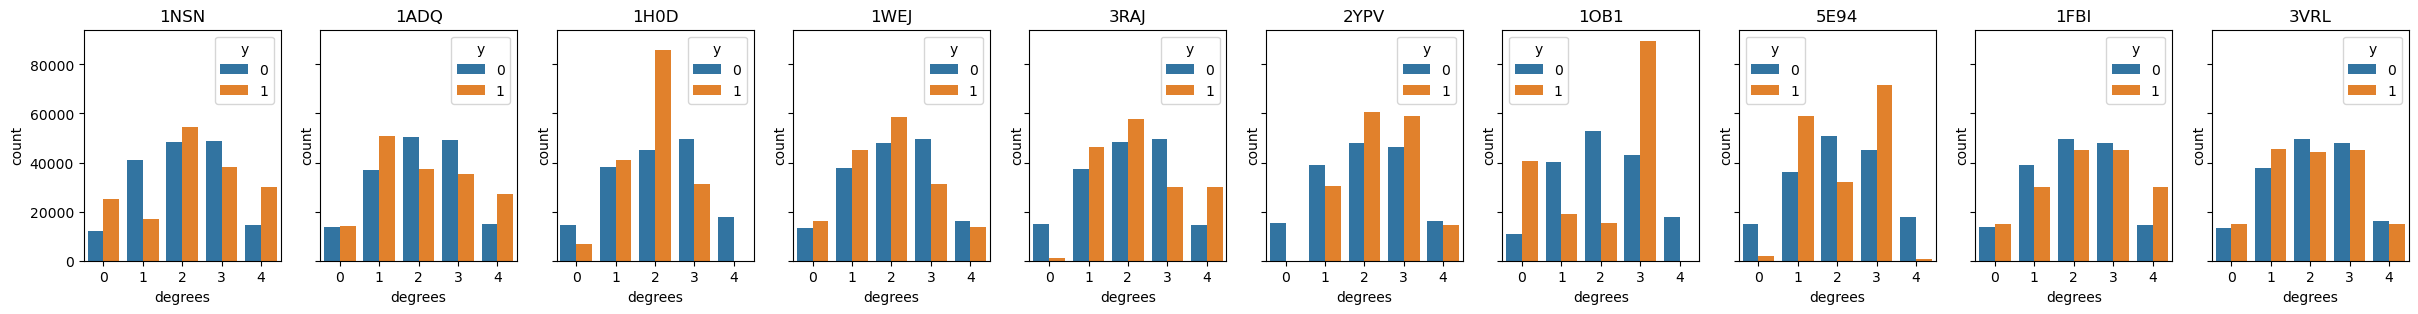

In [147]:
fig, ax = plt.subplots(1,10, sharex=True, sharey=True, figsize=(30,3))
task = 'ONE_VS_NINE'
for i, ag in enumerate(order_dict.keys()):
    seed_id, split_id = get_best_model_seed_split(perf_df, task, task, ag, 'acc')
    wt_path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/{tasks_dict[task]}/seed_{seed_id}/split_{split_id}/{task_template[task].format(ag=ag)}/*_train_dataset.tsv')[0] #this part with for loop is repeated a often, probably I just should store these dfs
    train_df = pd.read_csv(wt_path, sep='\t')
    df_merged = all_ag_imp_df.merge(train_df, how='inner', on=['Slide'])
    ax[i].set_title(ag)
    sns.countplot(x='degrees', hue='y', data=df_merged.explode('degrees'), ax=ax[i])
    #ax[i].text(0.05, 0.95, f'pos_ag {len(df_merged[df_merged['y']==1])}, neg_ag {len(df_merged[df_merged['y']==0])}', transform=ax[i,j].transAxes, fontsize=14, verticalalignment='top')
fig.savefig('./figures/aa_degrees_in_vs_all.svg')




In [86]:
#plor ro correlation with accurcy
acc_corr = []
for j, ag in enumerate(order_dict.keys()):
    for i, task in enumerate(tasks):
        mut_ig = pd.read_csv(f'./mutant_igs/{ag}_{task}_mut_igs.csv')
        acc = perf_df[(perf_df['train_ag'] == ag) & (perf_df['train_task'] == task) & (perf_df['test_task'] == task)]['acc'].max()
        acc = round(acc,2)
        corr_c = np.corrcoef(mut_ig['posn delta IG'].values, mut_ig['dEnergy'].values)[0,1]
        acc_corr.append([ag, task, acc, corr_c])
acc_corr = pd.DataFrame(acc_corr, columns=['ag', 'task', 'acc', 'corr_c'])
       

In [87]:
acc_corr = pd.DataFrame(acc_corr, columns=['ag', 'task', 'acc', 'corr_c'])

In [ ]:
    if task == 'ONE_VS_NINE' :
        color= '#FF5733'
    elif task == 'HIGH_VS_95LOW':
        
        color = '#00A6ED'
    else:
        color = '#FFC300'
    return color

Text(0, 0.5, 'Prediction accuracy')

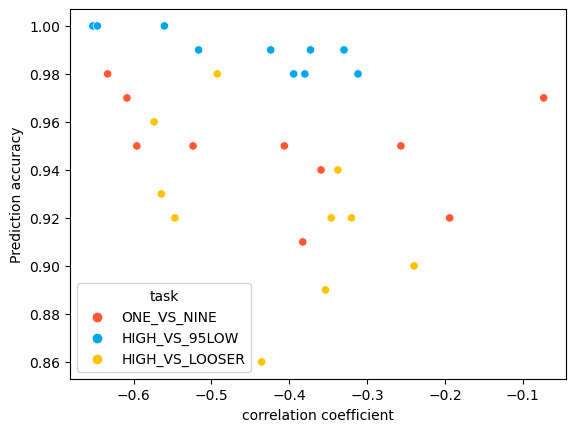

In [149]:
sns.scatterplot(x=corrs, y=accs, data=acc_corr, hue='task', palette=['#FF5733', '#00A6ED', '#FFC300'])
plt.xlabel('correlation coefficient')
plt.ylabel('Prediction accuracy')

In [62]:
# for 1 vs 1
for pos_ag in tqdm(config.ANTIGENS, desc='pos_ag'):
    seed_id = 0
    split_id = 0
    neg_ags = [x for x in config.ANTIGENS if x != pos_ag]
    mut_file = prep_mut_df(pos_ag)
    path_epi = glob.glob(f'../data/Slide_importance/{pos_ag}_[A-Z]_Task4_Slice_ParaEpi.txt')[0]
    para_epi = pd.read_csv(path_epi, sep='\t')
    for neg_ag in tqdm(neg_ags, desc='neg_ag'):
        wt_path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/1v1/seed_{seed_id}/split_{split_id}/{pos_ag}__vs__{neg_ag}/*_test_dataset.tsv')[0] #this part with for loop is repeated a often, probably I just should store these dfs
        slide_id_df = get_org_slide_id(mut_file, wt_path)
        #getting aa degrees
        slide_id_df= slide_id_df.merge(para_epi[['Slide', 'seqABParatope']], on=['Slide'], how='left')
        try:
            slide_id_df['aa_degrees'] = slide_id_df.apply(lambda x: full_slide_degree(x.Slide, x.seqABParatope), axis=1)
            slide_id_df.drop('seqABParatope', axis=1, inplace=True)

            ag_vs_one_path = f"./torch_models/Frozen_MiniAbsolut_ML/1v1/seed_{seed_id}/split_{split_id}/{pos_ag}__vs__{neg_ag}"               
            model_path = f"{ag_vs_one_path}/swa_model/data/model.pth"
            model = torch.load(model_path, map_location=torch.device('cpu'))
            ig = IntegratedGradients(model.cpu())
            mut_igs = mutant_ig(ig,mut_file, slide_id_df)
            mut_igs.to_csv(f'./mutant_igs/{pos_ag}__vs__{neg_ag}_mut_igs.csv', index=False)
        except:
            pass

pos_ag: 100%|██████████| 10/10 [19:42<00:00, 118.25s/it]


In [76]:
df_1vs1_ig_energy = []
for i, pos_ag in enumerate(config.ANTIGENS):
    neg_ags = [x for x in config.ANTIGENS if x != pos_ag]
    for j, neg_ag in enumerate(neg_ags):
        mut_ig = pd.read_csv(f'./mutant_igs/{pos_ag}__vs__{neg_ag}_mut_igs.csv')
        corr_c = np.corrcoef(mut_ig['posn delta IG'].values, mut_ig['dEnergy'].values)[0,1]
        corr_c = round(corr_c,2)
        df_1vs1_ig_energy.append([pos_ag, neg_ag, corr_c])
df_1vs1_ig_energy = pd.DataFrame(df_1vs1_ig_energy, columns=['pos_ag', 'neg_ag', 'corr_c'])


Text(50.722222222222214, 0.5, 'positive antigen')

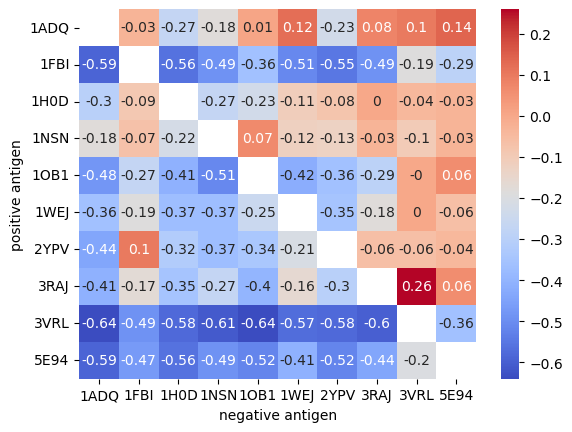

In [80]:
sns.heatmap(df_1vs1_ig_energy.pivot(index='pos_ag', columns='neg_ag', values='corr_c'), annot=True, cmap='coolwarm')
plt.xlabel('negative antigen')
plt.ylabel('positive antigen')
#will be good to correlate with accuracy

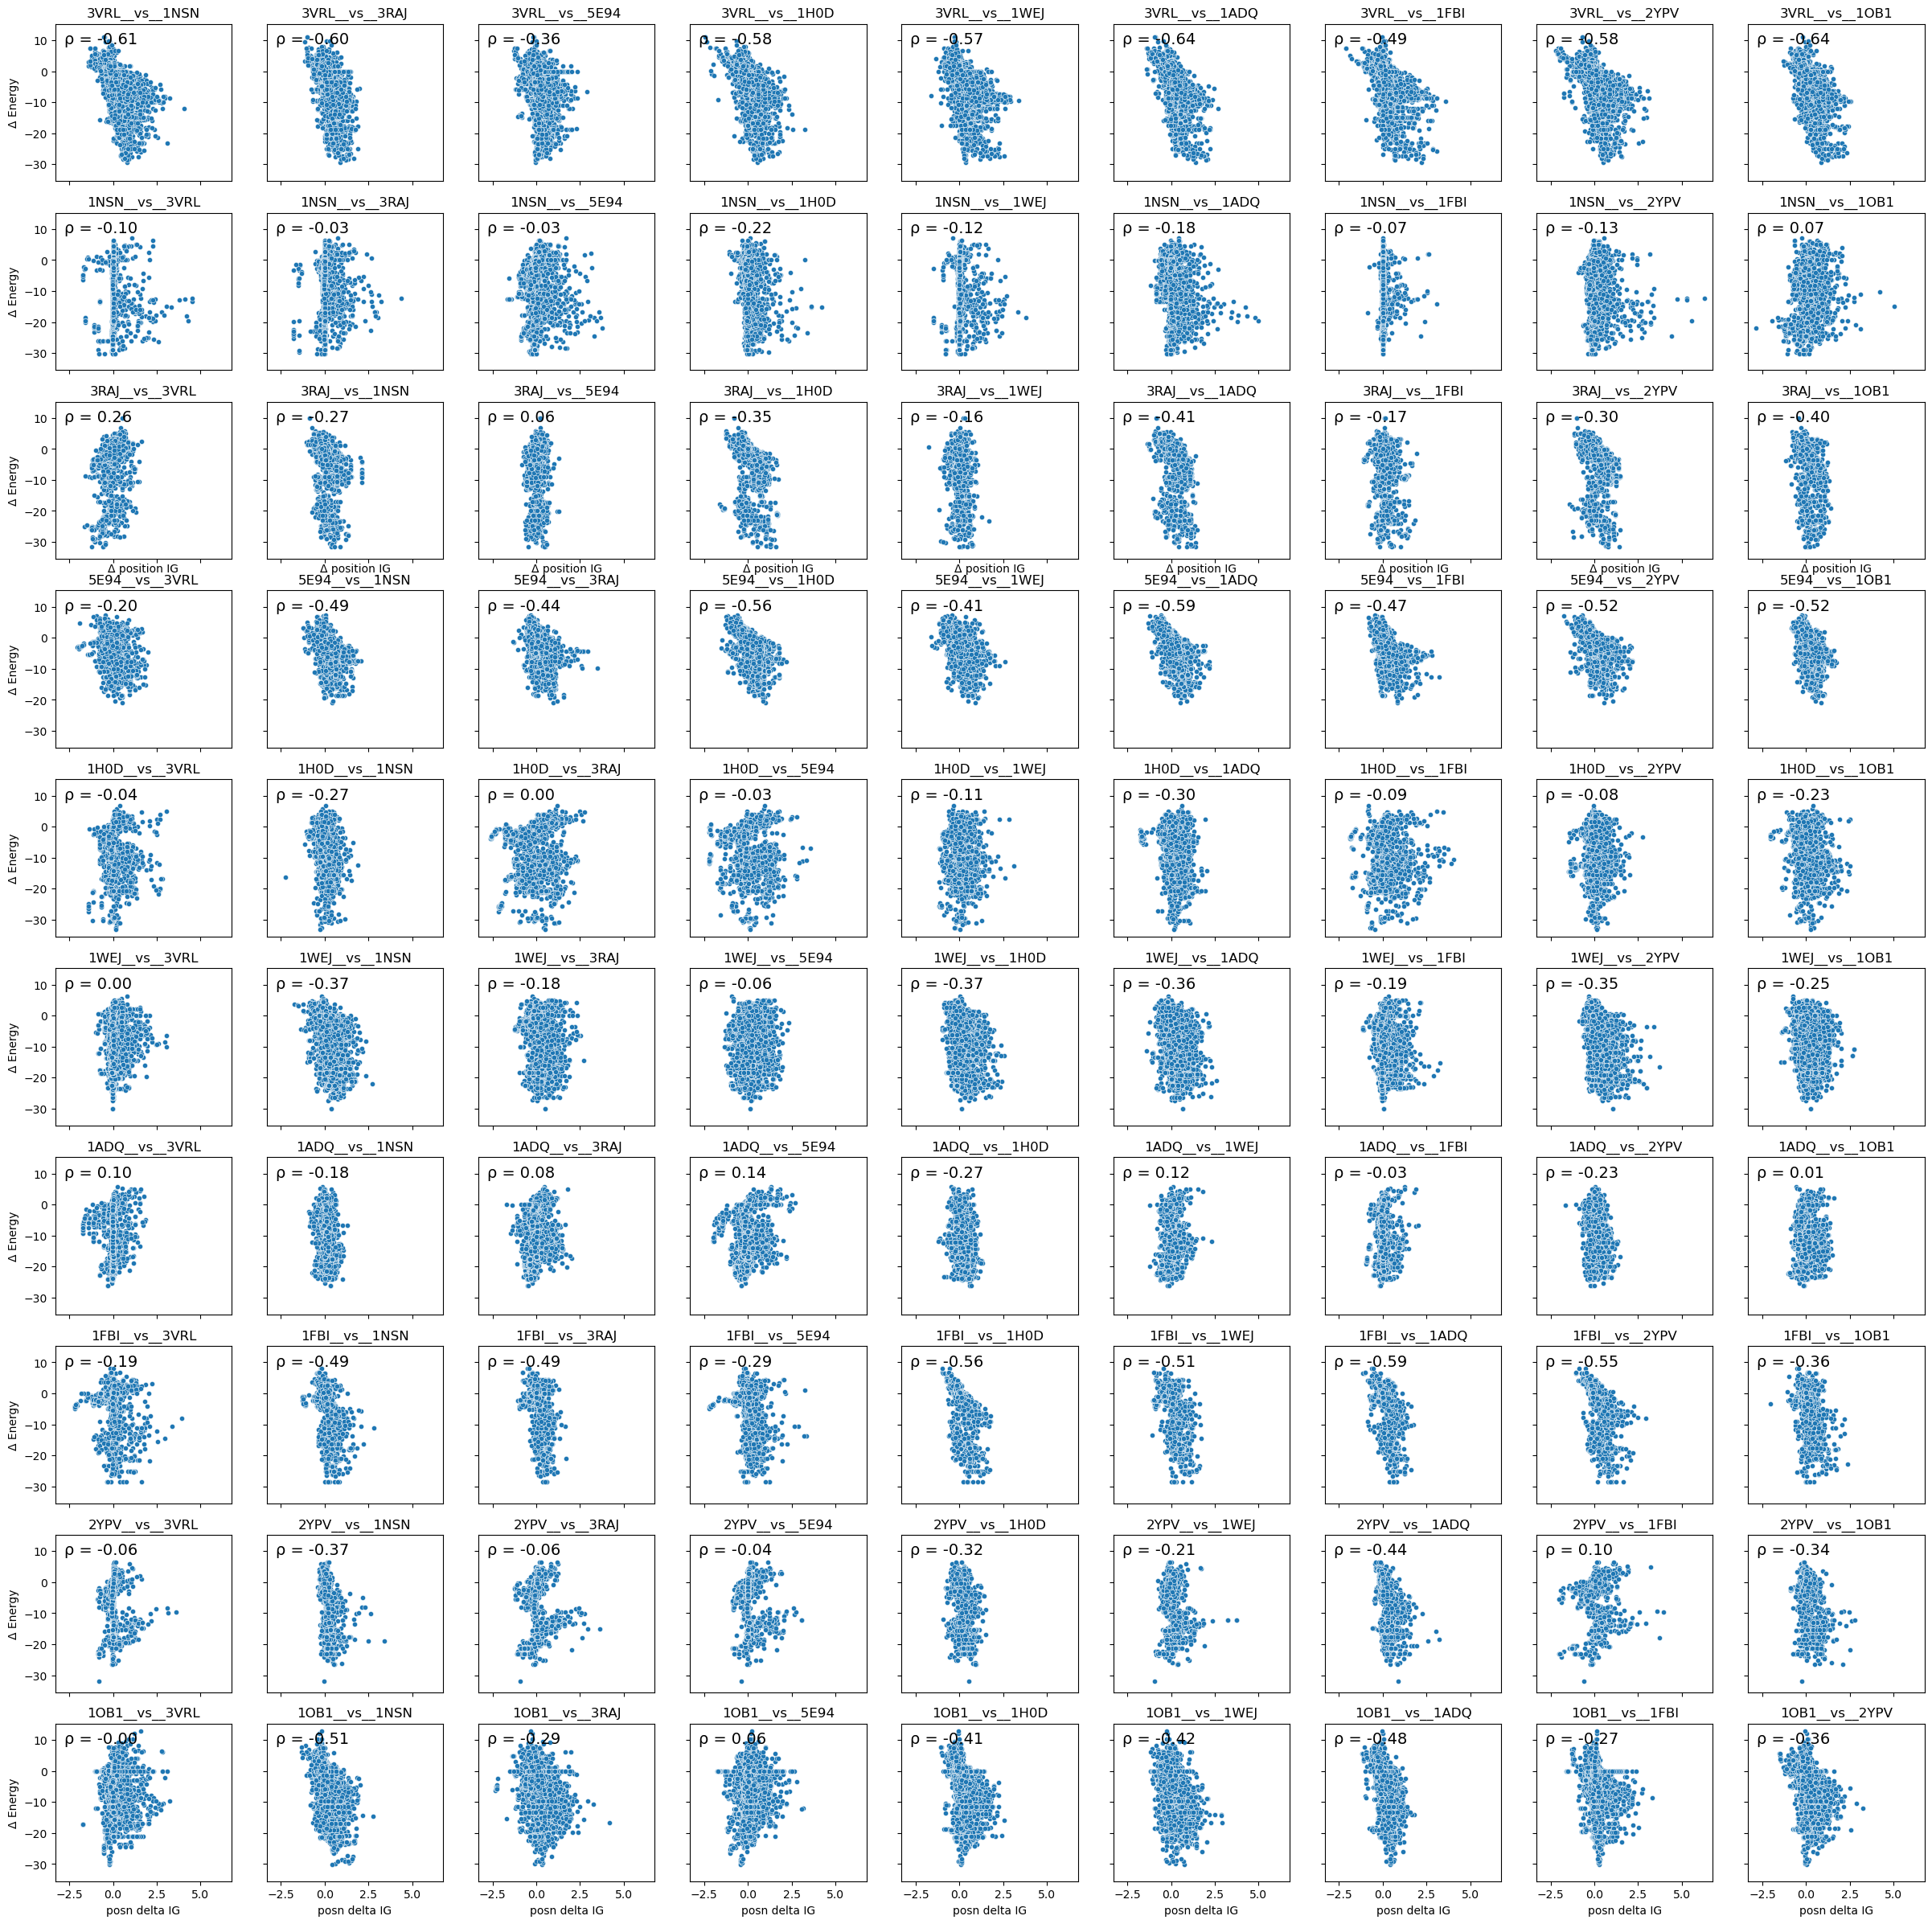

In [66]:
fig, ax = plt.subplots(10,9, figsize=(30,30),sharex=True, sharey=True)
for i, pos_ag in enumerate(config.ANTIGENS):
    neg_ags = [x for x in config.ANTIGENS if x != pos_ag]
    for j, neg_ag in enumerate(neg_ags):
        mut_ig = pd.read_csv(f'./mutant_igs/{pos_ag}__vs__{neg_ag}_mut_igs.csv')
        sns.scatterplot(mut_ig, x = 'posn delta IG', y='dEnergy', s=20, ax=ax[i,j])#hue='degree wt'
       #insert text to each sublot
        ax[i,j].text(0.05, 0.95, 'ρ = {:.2f}'.format(np.corrcoef(mut_ig['posn delta IG'].values, mut_ig['dEnergy'].values)[0,1]), transform=ax[i,j].transAxes, fontsize=14, verticalalignment='top')
        ax[i,0].set_ylabel(f'dEnergy')
        #rename x-axis
        ax[2,j].set_xlabel('Δ position IG')
        #rename y-axis
        ax[i,0].set_ylabel('Δ Energy')
        ax[i,j].set_title(f'{pos_ag}__vs__{neg_ag}')

## Calculating IG for all test sequences

In [56]:
for ag in config.ANTIGENS:
    wt_path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/1v9/seed_0/split_0/{ag}__vs__9/*_test_dataset.tsv')[0]
    wt_df = pd.read_csv(wt_path, sep='\t')
    binder_df = wt_df[wt_df['y'] == 1]
    binder_df['X'] = binder_df.Slide.apply(onehot_encode)
    # get degree of each slide
    path_epi = glob.glob(f'../data/Slide_importance/{ag}_[A-Z]_Task4_Slice_ParaEpi.txt')[0]
    para_epi = pd.read_csv(path_epi, sep='\t')
    binder_df= binder_df.merge(para_epi[['Slide', 'seqABParatope']], on=['Slide'], how='left')
    binder_df['aa_degrees'] = binder_df.apply(lambda x: full_slide_degree(x.Slide, x.seqABParatope), axis=1)
    binder_df['degrees'] = binder_df['aa_degrees'].apply(lambda d: list(map(lambda x: int(re.search('(\d)',x).group(1)),d)))
    binder_df.drop('seqABParatope', axis=1, inplace=True)

    for task in tasks:
        seed_id, split_id = get_best_model_seed_split(perf_df, task, task, ag, 'acc')
        model_path = f"./torch_models/Frozen_MiniAbsolut_ML/{tasks_dict[task]}/seed_{seed_id}/split_{split_id}/{task_template[task].format(ag=ag)}/swa_model/data/model.pth"
        model = torch.load(model_path, map_location=torch.device('cpu'))
        ig = IntegratedGradients(model.cpu())
        binder_df['IG'] = binder_df.X.apply(lambda x: ig_from_oh(x,ig,baseline))
        binder_df.to_csv(f'./binder_igs/{ag}_{task}_binder_igs.csv', index=False)

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_77727/210821106.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binder_df['X'] = binder_df.Slide.apply(onehot_encode)
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_77727/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_77727/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_77

In [25]:
task = 'ONE_VS_NINE'
order_dict = dict()
for ag in config.ANTIGENS:
    ig_df = pd.read_csv(f'./binder_igs/{ag}_{task}_binder_igs.csv')
    ig_df['IG'] = ig_df['IG'].apply(eval)
    ig_df['degrees'] = ig_df['degrees'].apply(eval)
        # create df with ig and degree correspondance 
    igs = np.concatenate(ig_df['IG'].values).astype(float)
    degrees = np.concatenate(ig_df['degrees'].values).astype(int)
    df_degree_ig = pd.DataFrame.from_dict({'degree': degrees, 'IG': igs})
    order_dict[ag] = np.corrcoef(df_degree_ig['degree'].values, df_degree_ig['IG'].values)[0,1]

In [26]:
order_dict
order_dict = {k: v for k, v in sorted(order_dict.items(), key=lambda item: item[1])}

In [27]:
order_dict

{'1NSN': -0.4423994789235985,
 '1H0D': -0.28370929649712934,
 '1ADQ': -0.0032288779708532053,
 '2YPV': 0.032518100719305006,
 '1WEJ': 0.1257234742535492,
 '1OB1': 0.19204966473114404,
 '1FBI': 0.2765363323910073,
 '5E94': 0.46500462982794616,
 '3VRL': 0.48316998231615477,
 '3RAJ': 0.5679816212601967}

In [28]:
order_dict

{'1NSN': -0.4423994789235985,
 '1H0D': -0.28370929649712934,
 '1ADQ': -0.0032288779708532053,
 '2YPV': 0.032518100719305006,
 '1WEJ': 0.1257234742535492,
 '1OB1': 0.19204966473114404,
 '1FBI': 0.2765363323910073,
 '5E94': 0.46500462982794616,
 '3VRL': 0.48316998231615477,
 '3RAJ': 0.5679816212601967}

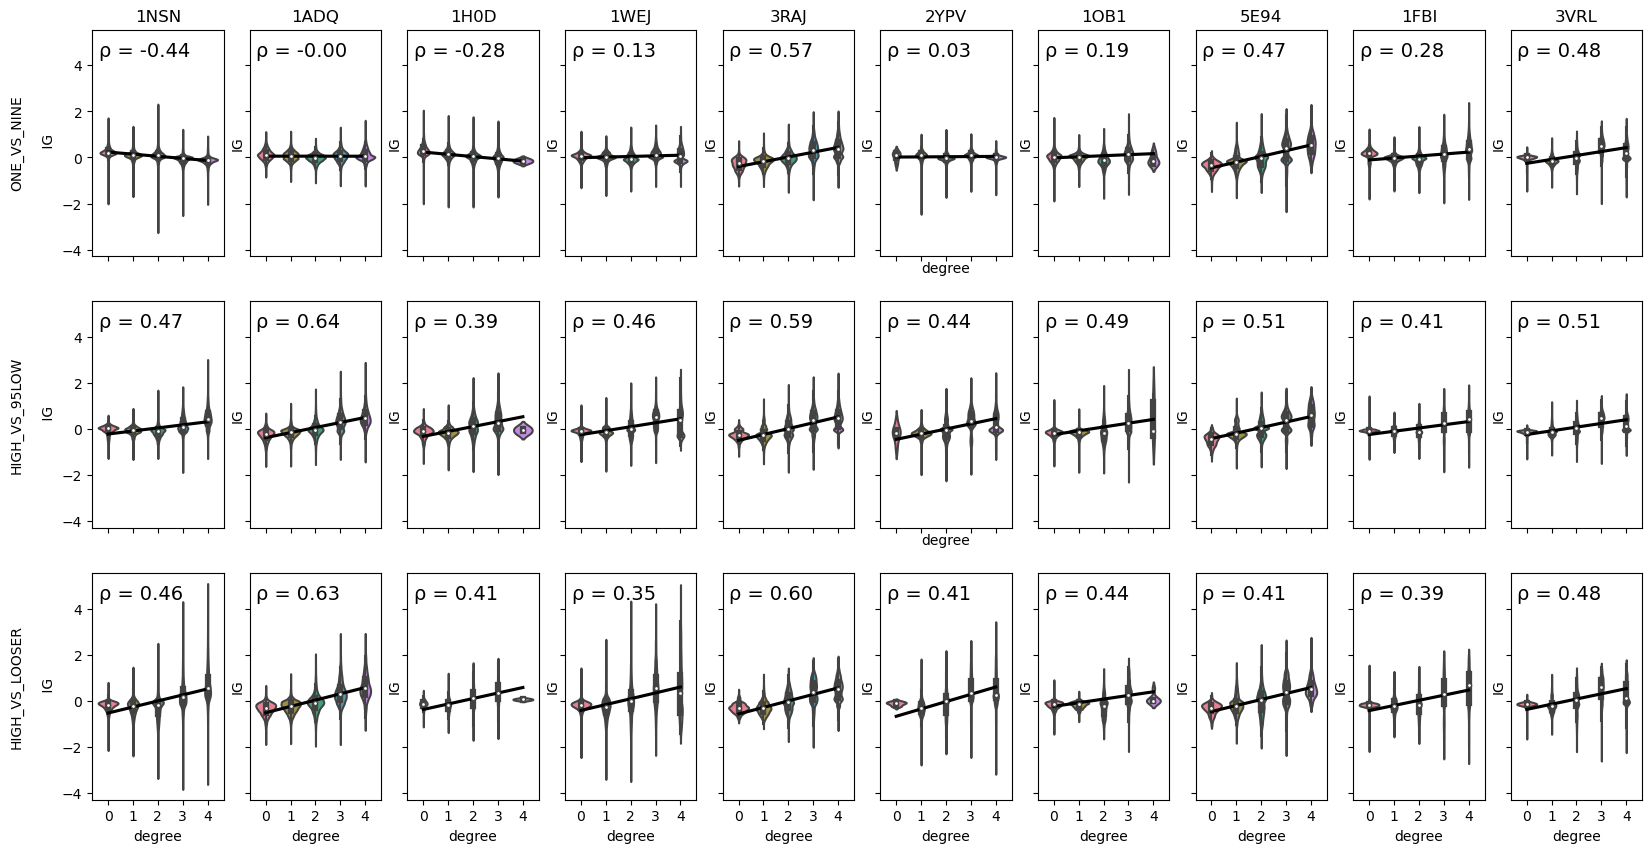

In [143]:
fig, ax = plt.subplots(3,10, sharex=True, sharey=True, figsize=(20,10))
for i, task in enumerate(tasks):
    for j, ag in enumerate(order_dict.keys()):
        #converters = {'IG': pd.eval, 'degrees': pd.eval}
        ig_df = pd.read_csv(f'./binder_igs/{ag}_{task}_binder_igs.csv')
        ig_df['IG'] = ig_df['IG'].apply(eval)
        ig_df['degrees'] = ig_df['degrees'].apply(eval)
        # create df with ig and degree correspondance 
        igs = np.concatenate(ig_df['IG'].values).astype(float)
        degrees = np.concatenate(ig_df['degrees'].values).astype(int)
        df_degree_ig = pd.DataFrame.from_dict({'degree': degrees, 'IG': igs})

        r = i
        c = j
        sns.violinplot(df_degree_ig,x='degree', y='IG', ax=ax[r,c], palette='husl')
        sns.regplot(df_degree_ig,x='degree', y='IG', ax=ax[r,c], scatter=False, color='black')
        ax[r,c].text(0.05, 0.95, 'ρ = {:.2f}'.format(np.corrcoef(df_degree_ig['degree'].values, df_degree_ig['IG'].values)[0,1]), transform=ax[r,c].transAxes, fontsize=14, verticalalignment='top')
        #remove x-axis label except last row
        if (r != 2) and (c != 5):
            ax[r,c].set_xlabel('')
        #despine sns.despine()
        #title of sublots
        ax[0,c].set_title(ag)
    ax[r,0].set_ylabel(f'{task}\n\n IG')
fig.savefig('./figures/mut_igs_degree.svg', dpi=600)


In [84]:
seed_id, split_id = get_best_model_seed_split(perf_df, task, task, ag, 'acc')
train_data_path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/{tasks_dict[task]}/seed_{seed_id}/split_{split_id}/{task_template[task].format(ag=ag)}/*_train_dataset.tsv')[0]
train_df = pd.read_csv(train_data_path, sep='\t')
path_epi = glob.glob(f'../data/Slide_importance/{ag}_[A-Z]_Task4_Slice_ParaEpi.txt')[0]
para_epi = pd.read_csv(path_epi, sep='\t')
train_df= train_df.merge(para_epi[['Slide', 'seqABParatope']], on=['Slide'], how='left')
train_df['aa_degrees'] = train_df.apply(lambda x: full_slide_degree(x.Slide, x.seqABParatope), axis=1)
train_df.drop('seqABParatope', axis=1, inplace=True)

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]


TypeError: 'float' object is not subscriptable

In [82]:
#loose
pd.read_csv(train_data_path, sep='\t').head()

Slide  binds_a_pos_ag  \
0  AAAVLLRYLYY               1   
1  AAFITTVVARF               0   
2  AAFYGNLAWFA               0   
3  AAFYYDYPAWF               0   
4  AAGLLLAWFAY               1   

                                        Slide_onehot  \
0  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...   
1  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...   
2  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...   
3  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...   
4  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...   

                                                   X  y  
0  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...  1  
1  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...  0  
2  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...  0  
3  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...  0  
4  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...  1

## Try DeepLift

In [160]:
from NegativeClassOptimization import ml

In [163]:
df['mut OH'].iloc[0]

tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [207]:
#read (f'./mutant_igs/{ag}_{task}_mut_igs.csv', index=False)

for ag in config.ANTIGENS:
    for task in tasks:

        df = pd.read_csv(f'./mutant_igs/{ag}_{task}_mut_igs.csv')
        df['mut OH'] = df['Slide'].apply(lambda x: [onehot_encode(x)])
        df['mut OH'] = df['mut OH'].apply(lambda x: torch.tensor(np.array(x, dtype=float)).float())
        df['org OH'] = df['original Slide'].apply(lambda x: [[onehot_encode(x)]])
        df['org OH'] = df['org OH'].apply(lambda x: torch.tensor(np.array(x, dtype=float)).float())


        # change this to torch tensor
        seed_id, split_id = get_best_model_seed_split(perf_df, task, task, ag, 'acc')
        model_path = f"./torch_models/Frozen_MiniAbsolut_ML/{tasks_dict[task]}/seed_{seed_id}/split_{split_id}/{task_template[task].format(ag=ag)}/swa_model/data/model.pth"
        model = torch.load(model_path)
        model.__class__ = ml.SN10()
        
        
        attributor = ml.Attributor(model,
            type="deep_lift", 
            baseline_type="shuffle",
            compute_on="logits",
            multiply_by_inputs=False,)

        df['org DeepLift'] = df['mut OH'].apply(lambda x: attributor.attribute(x, return_baseline=False))
        df['org DeepLift'] = df['org OH'].apply(lambda x: attributor.attribute(x, return_baseline=False))

        break
    break
    #mut_igs.to_csv(f'./mutant_igs/{ag}_{task}_mut_igs.csv', index=False)

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24903/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


AttributeError: 'AveragedModel' object has no attribute 'forward_logits'

In [176]:
x = df['org OH'].iloc[0]

In [177]:
model(x, return_logits = True)

(tensor([[0.1685]], grad_fn=<SigmoidBackward0>),
 tensor([[-1.5966]], grad_fn=<AddmmBackward0>))

In [180]:
model_path

'./torch_models/Frozen_MiniAbsolut_ML/1v9/seed_0/split_0/3VRL__vs__9/swa_model/data/model.pth'

AttributeError: 'AveragedModel' object has no attribute 'keys'

In [197]:
model = torch.load(model_path)
#remove final layer from the model
#model = torch.nn.Sequential(*list(model.children())[:-1])

In [201]:
model

AveragedModel(
  (module): SNN(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear_1): Linear(in_features=220, out_features=10, bias=True)
    (activation): ReLU()
    (linear_2): Linear(in_features=10, out_features=1, bias=True)
    (final): Sigmoid()
  )
)

In [200]:
ml.SN10()

SN10(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=220, out_features=10, bias=True)
  (activation): ReLU()
  (linear_2): Linear(in_features=10, out_features=1, bias=True)
  (final): Sigmoid()
)

In [202]:
model.__class__ = ml.SN10()

In [206]:
type(model)

torch.optim.swa_utils.AveragedModel

In [185]:
torch.load?

Signature:
torch.load(
    f,
    map_location=None,
    pickle_module=<module 'pickle' from '/opt/homebrew/anaconda3/envs/nco/lib/python3.8/pickle.py'>,
    **pickle_load_args,
)
Docstring:
load(f, map_location=None, pickle_module=pickle, **pickle_load_args)

Loads an object saved with :func:`torch.save` from a file.

:func:`torch.load` uses Python's unpickling facilities but treats storages,
which underlie tensors, specially. They are first deserialized on the
CPU and are then moved to the device they were saved from. If this fails
(e.g. because the run time system doesn't have certain devices), an exception
is raised. However, storages can be dynamically remapped to an alternative
set of devices using the :attr:`map_location` argument.

If :attr:`map_location` is a callable, it will be called once for each serialized
storage with two arguments: storage and location. The storage argument
will be the initial deserialization of the storage, residing on the CPU.
Each serialized storage 

In [183]:
model.load_state_dict?

Signature: model.load_state_dict(state_dict: Mapping[str, Any], strict: bool = True)
Docstring:
Copies parameters and buffers from :attr:`state_dict` into
this module and its descendants. If :attr:`strict` is ``True``, then
the keys of :attr:`state_dict` must exactly match the keys returned
by this module's :meth:`~torch.nn.Module.state_dict` function.

Args:
    state_dict (dict): a dict containing parameters and
        persistent buffers.
    strict (bool, optional): whether to strictly enforce that the keys
        in :attr:`state_dict` match the keys returned by this module's
        :meth:`~torch.nn.Module.state_dict` function. Default: ``True``

Returns:
    ``NamedTuple`` with ``missing_keys`` and ``unexpected_keys`` fields:
        * **missing_keys** is a list of str containing the missing keys
        * **unexpected_keys** is a list of str containing the unexpected keys

Note:
    If a parameter or buffer is registered as ``None`` and its corresponding key
    exists in :attr

In [ ]:
            df_pos_mut = df_search[df_search['Slide'].str.contains(pattern)].copy(deep=True)
            df_pos_mut['mut OH'] = df_pos_mut['Slide'].apply(lambda x: [[onehot_encode(x)]])
            df_pos_mut['IG mut'] = df_pos_mut['mut OH'].apply(lambda x: ig_from_oh(x,ig,baseline))
            df_pos_mut['degree wt'] = int(degrees[i][1])
            df_pos_mut['posn IG mut'] = df_pos_mut['IG mut'].apply(lambda x: x[i])
            df_pos_mut['posn IG org'] = df_pos_mut['IG org'].apply(lambda x: x[i])
            df_pos_mut['posn delta IG'] =  df_pos_mut['posn IG org'] - df_pos_mut['posn IG mut']
            df_pos_mut['dEnergy'] = [Energy]*df_pos_mut.shape[0] - df_pos_mut['Energy']
            dfs_list.append(df_pos_mut)

In [ ]:
#save temp
fig, ax = plt.subplots(1,1,figsize= (5 * 3.14, 10* 3.14), sharey=True, sharex=True)
sns.heatmap(df_open_full.pivot_table(index=['train_task','train_neg','test_task','test_neg'], columns=['train_ag'], values='acc'), cmap='viridis', ax=ax, annot=True, fmt=".2f")
#color rowlabels by 'train_task'
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
for tick in ax.get_yticklabels():
    #get label name
    label = tick.get_text()
    label = label.split('-')[0]
    #set color
    if label == 'vs Non':
        label = 'vs Non-binder'
    tick.set_color(cmap[label])

fig.savefig('./figures/openset_performance_with1_heatmap.svg')